# An√°lisis y tratamiento de valores faltantes en dataset del tit√°nic

Este notebook analiza el tratamiento de valores faltantes en el dataset del Titanic, implementando diferentes estrategias de imputaci√≥n y validaci√≥n

**Contenido**:
1. An√°lisis detallado de Missingness

2. Estrategias de imputaci√≥n

3. Validaci√≥n de imputaciones

## Importar librer√≠as


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import missingno as msno

In [83]:
# Configuraciones de visualizaci√≥n
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
df = pd.read_csv('../data/Titanic-Dataset-Canvas.csv')

# Mostrar informaci√≥n inicial
print("Dimensiones del dataset:", df.shape)
print("\nInformaci√≥n del dataset:")
print(df.info())

Dimensiones del dataset: (891, 12)

Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## 1. An√°lisis Detallado de Missingness


### 1.1 Patr√≥n de Missingness
Analizaremos si los valores faltantes siguen un patr√≥n MCAR (Missing Completely at Random), MAR (Missing at Random) o MNAR (Missing Not at Random).

In [84]:
# An√°lisis de valores faltantes
print("1. An√°lisis de Valores Faltantes:")
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje': missing_percentages
}).sort_values('Porcentaje', ascending=False)

print(missing_info[missing_info['Valores Faltantes'] > 0])

1. An√°lisis de Valores Faltantes:
          Valores Faltantes  Porcentaje
Cabin                   687   77.104377
Age                     177   19.865320
Embarked                  2    0.224467


### 1.1.2 Visualizaci√≥n de Patrones de Valores Faltantes
Utilizamos la librer√≠a `missingno` para visualizar los patrones de datos faltantes y detectar posibles correlaciones entre las ausencias.

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\111619552.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x600 with 0 Axes>

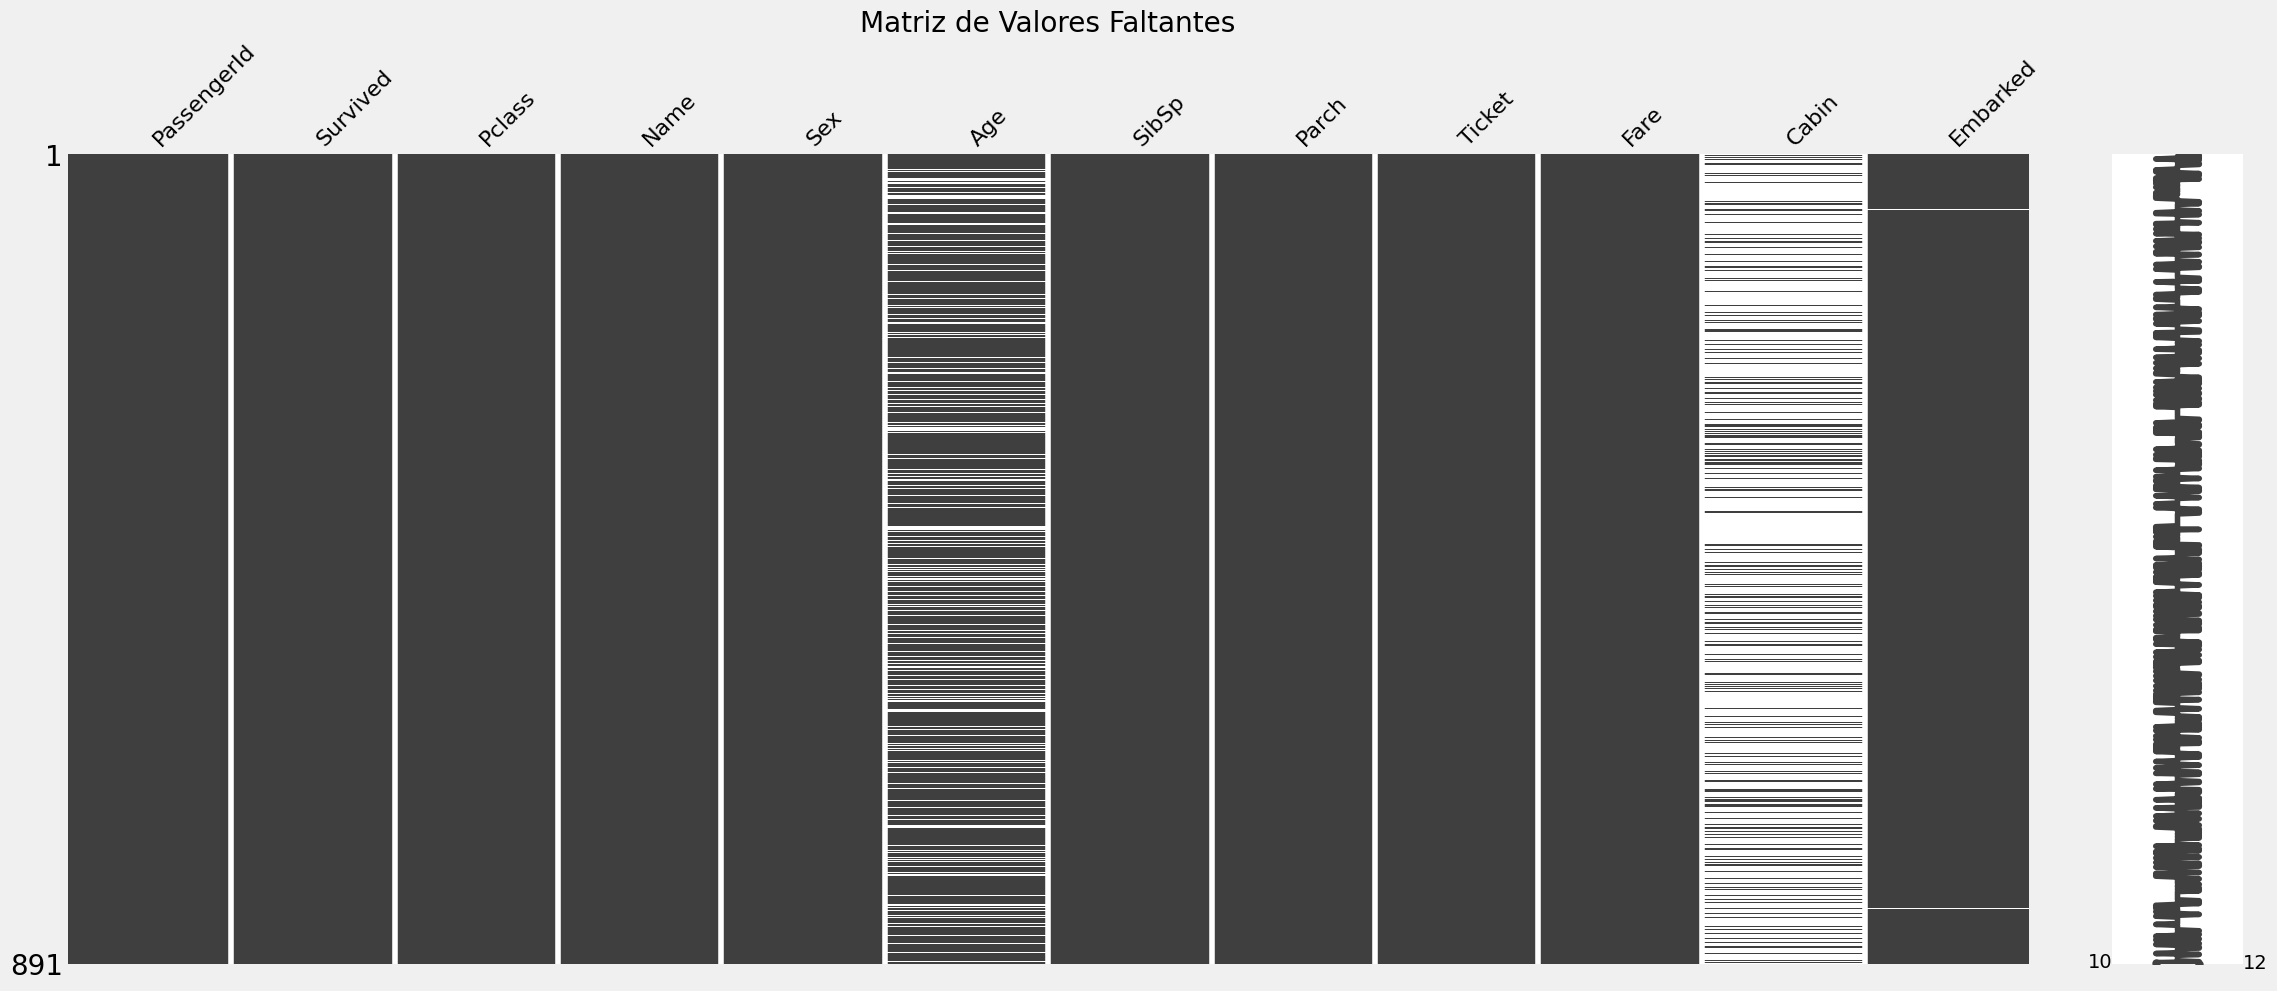

In [85]:
# Visualizaci√≥n de patrones de valores faltantes
plt.figure(figsize=(15, 6))
msno.matrix(df)
plt.title('Matriz de Valores Faltantes')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

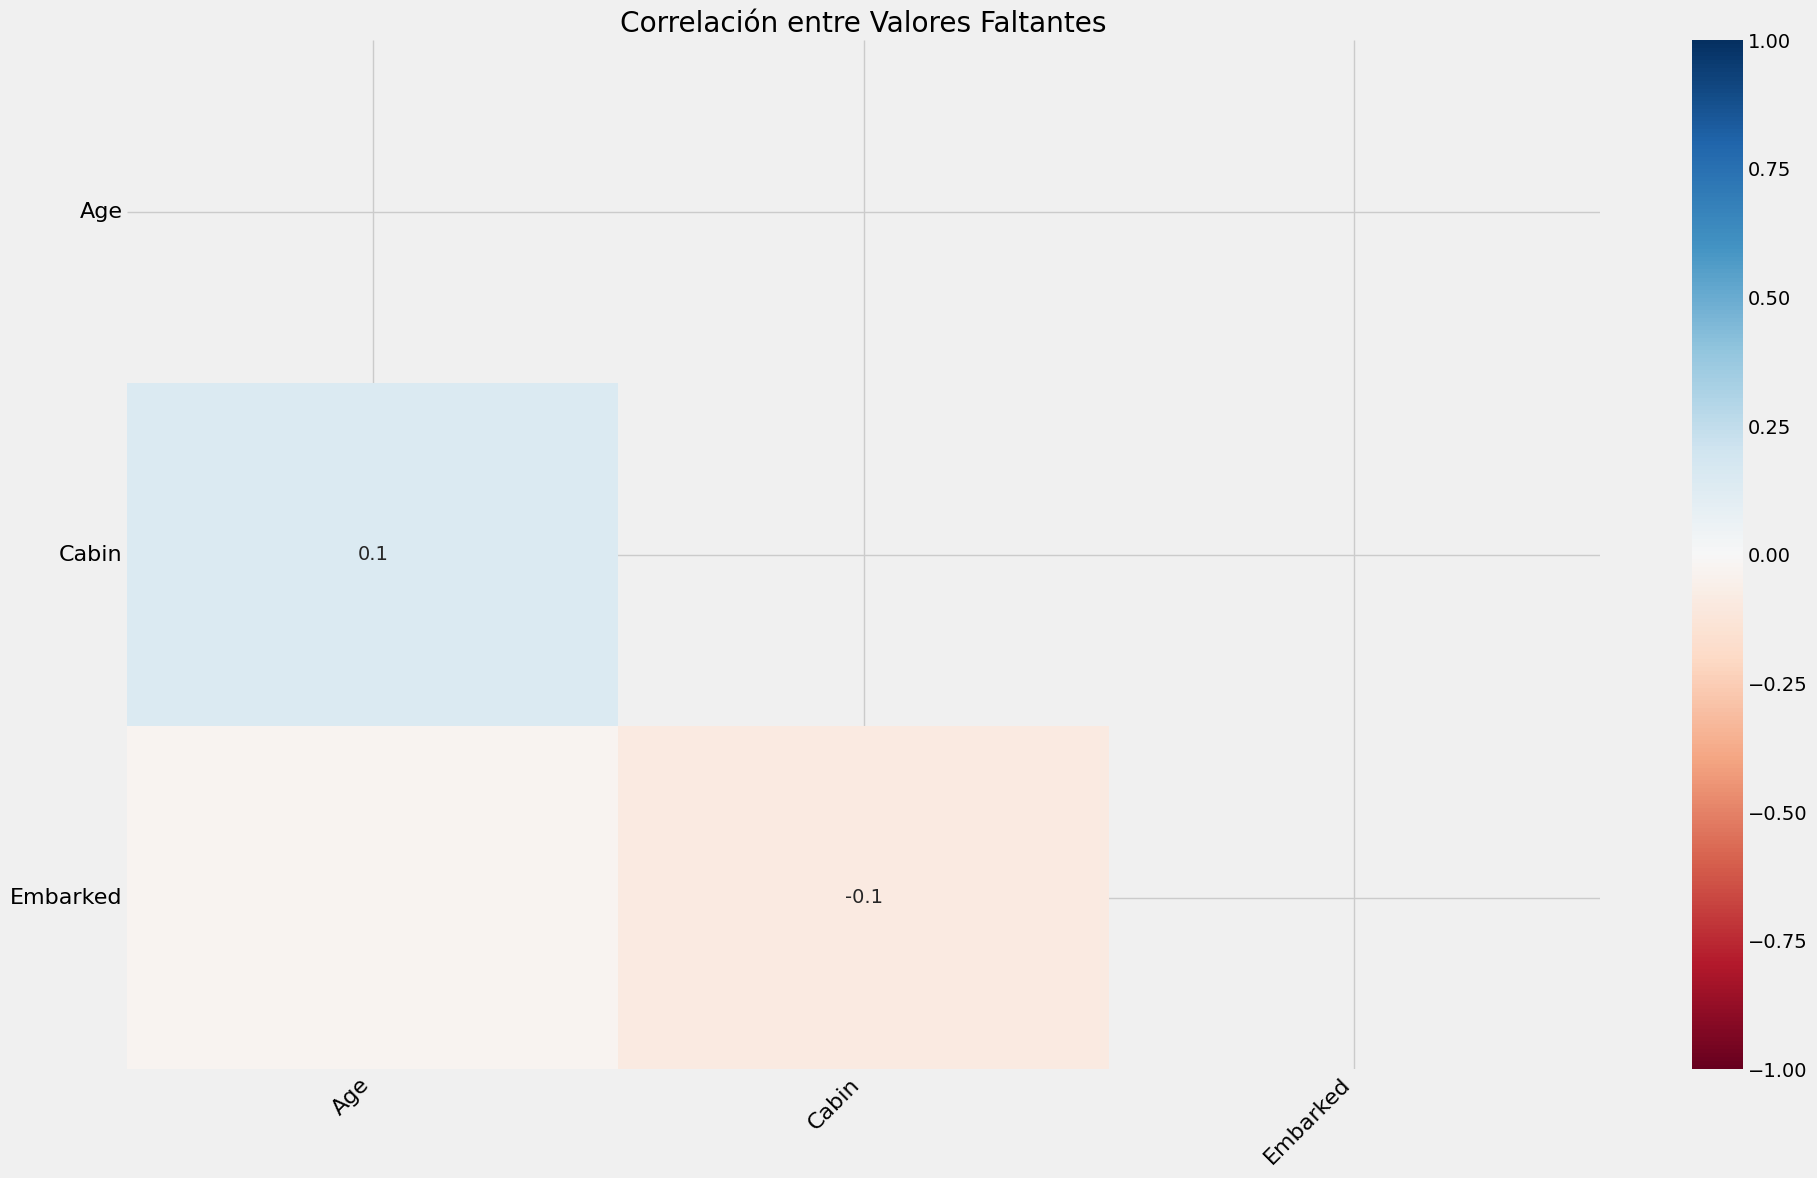

In [86]:
# Heatmap de correlaci√≥n entre valores faltantes
plt.figure(figsize=(12, 8))
msno.heatmap(df)
plt.title('Correlaci√≥n entre Valores Faltantes')
plt.tight_layout()
plt.show()

### 1.1.3 An√°lisis de Variables Num√©ricas
Examinamos las estad√≠sticas descriptivas y distribuciones de las variables num√©ricas para entender mejor los datos.

In [87]:
# An√°lisis de variables num√©ricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("2. Estad√≠sticas de Variables Num√©ricas:")
print(df[numeric_cols].describe())

2. Estad√≠sticas de Variables Num√©ricas:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


### 1.1.4 Distribuciones de Variables Num√©ricas
Visualizamos la distribuci√≥n de cada variable num√©rica para identificar patrones, sesgos y posibles outliers.

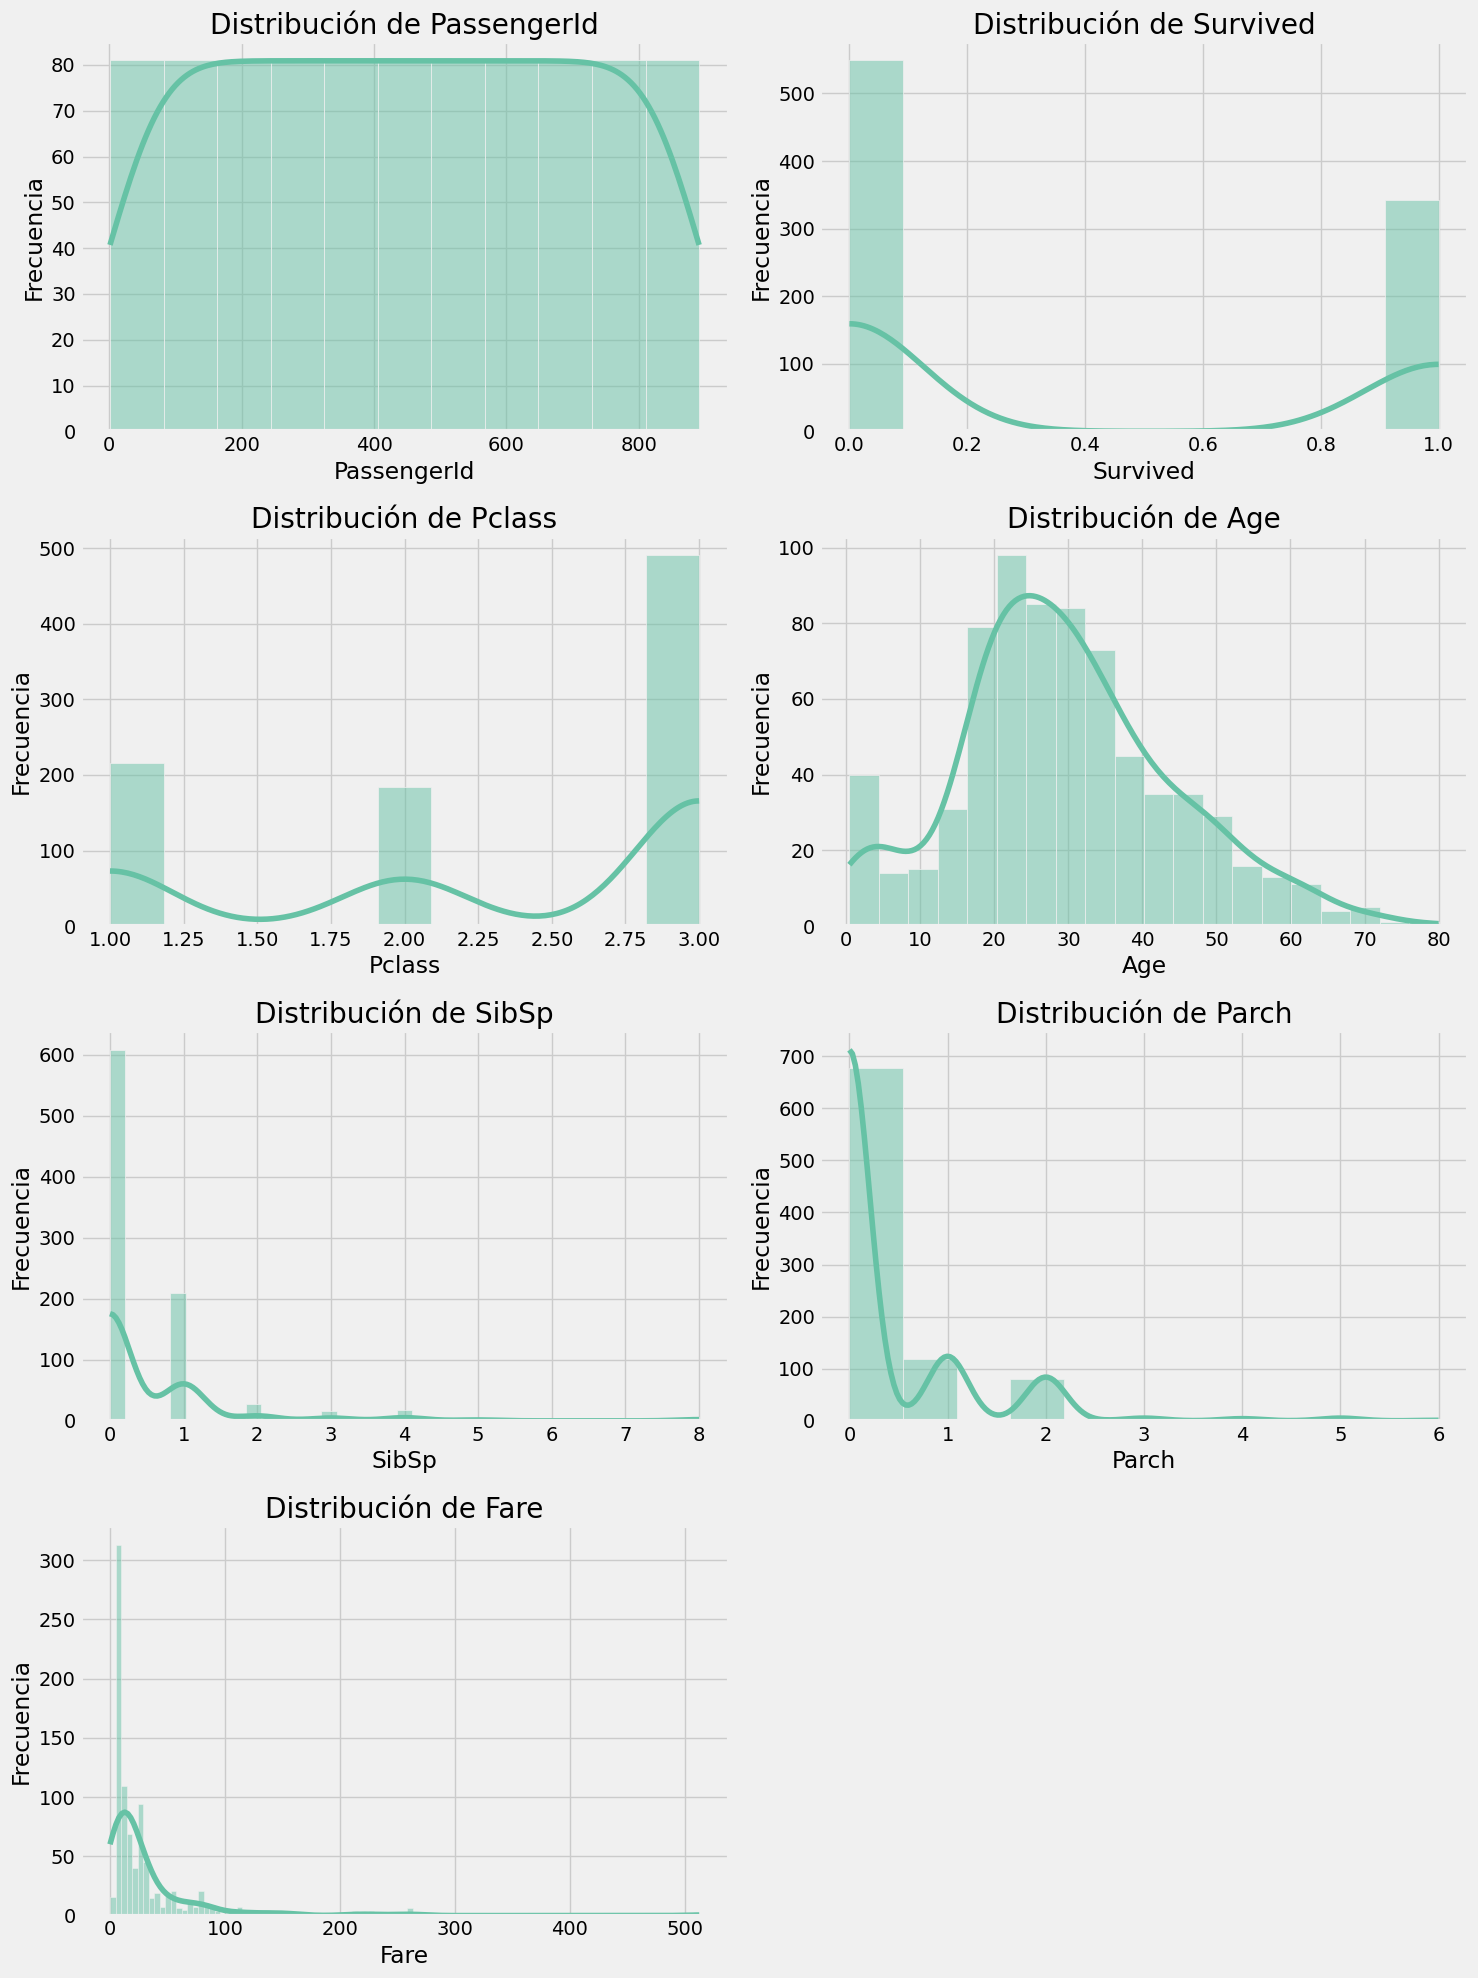

In [88]:
# Visualizaci√≥n de distribuciones num√©ricas
n_cols = len(numeric_cols)
n_rows = (n_cols + 1) // 2
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuci√≥n de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### 1.1.5 An√°lisis de Variables Categ√≥ricas
Exploramos las variables categ√≥ricas para comprender su distribuci√≥n y la presencia de valores faltantes.

In [89]:
# An√°lisis de variables categ√≥ricas
categorical_cols = df.select_dtypes(include=['object']).columns
print("3. An√°lisis de Variables Categ√≥ricas:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Valores √∫nicos: {df[col].nunique()}")
    print(f"Valores faltantes: {df[col].isnull().sum()}")

3. An√°lisis de Variables Categ√≥ricas:

Name:
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Hewlett, Mrs. (Mary D Kingcome)                        1
Vestrom, Miss. Hulda Amanda Adolfina                   1
Andersson, Mr. Anders Johan                            1
Saundercock, Mr. William Henry                         1
Bonnell, Miss. Elizabeth                               1
Name: count, Length: 891, dtype: int64
Valores √∫nicos: 891
Valores faltantes: 0

Sex:
Sex
male      577
female    314
Name: count, dtype: int64
Valores √∫nicos: 2
Valores faltantes: 0

Ticket:
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
          

### 1.1.6 Relaciones con la Variable Objetivo (Supervivencia)
Analizamos c√≥mo se relacionan las diferentes variables con la supervivencia para entender qu√© factores podr√≠an ser importantes para la imputaci√≥n.

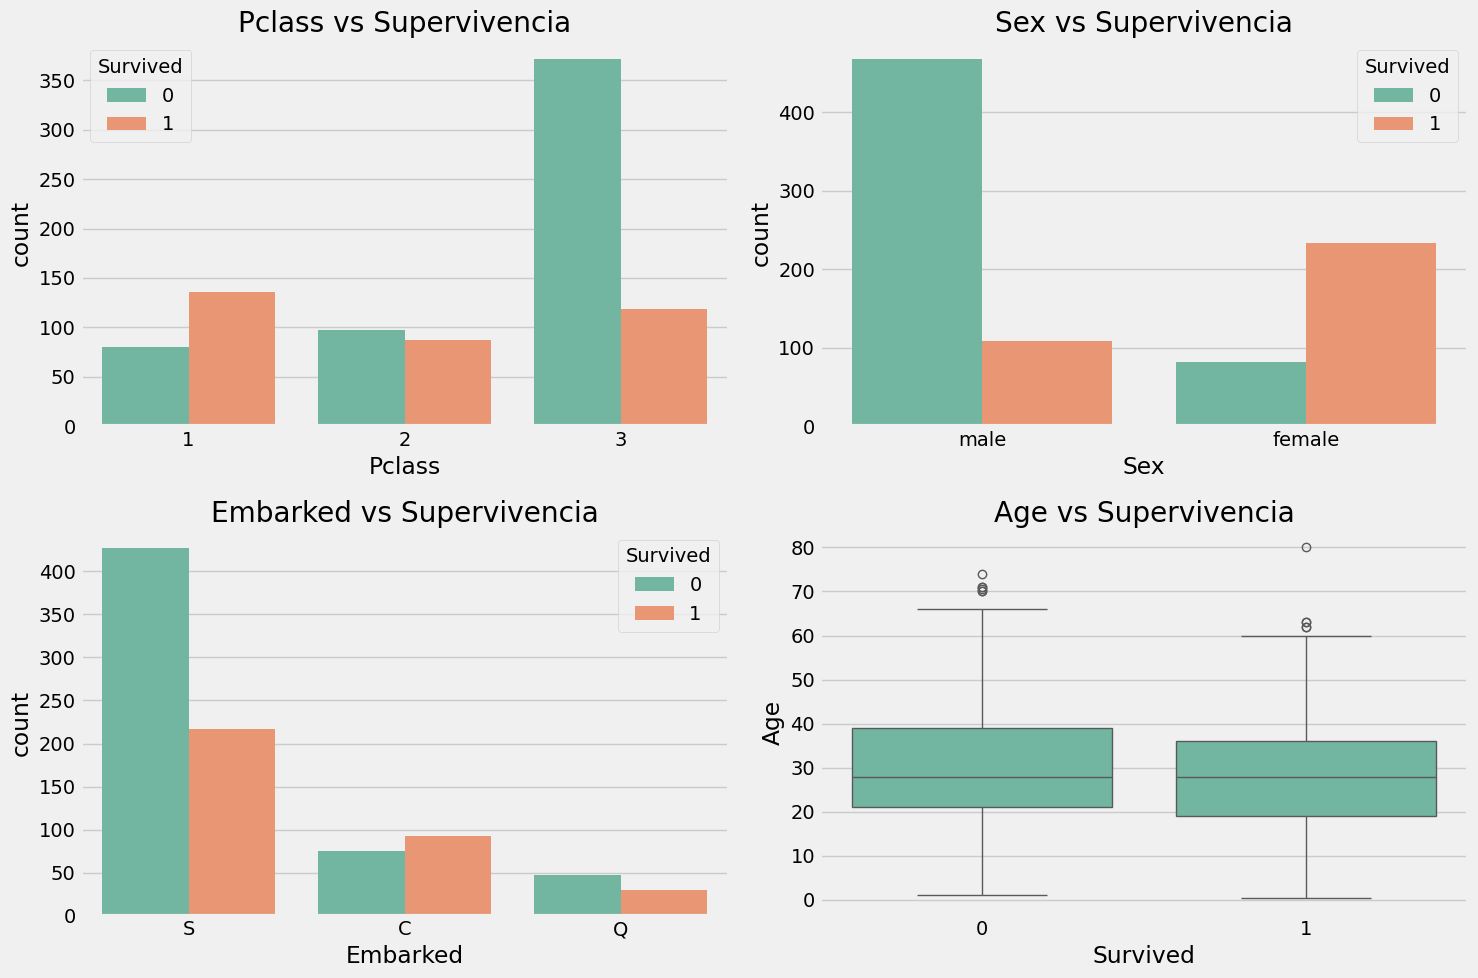

In [90]:
# Visualizaci√≥n de relaciones con la supervivencia
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Pclass', 'Sex', 'Embarked', 'Age'], 1):
    plt.subplot(2, 2, i)
    if col == 'Age':
        sns.boxplot(x='Survived', y=col, data=df)
    else:
        sns.countplot(data=df, x=col, hue='Survived')
    plt.title(f'{col} vs Supervivencia')
plt.tight_layout()
plt.show()

### 1.1.7 Matriz de Correlaci√≥n
Examinamos las correlaciones entre variables num√©ricas para identificar relaciones que puedan ser √∫tiles en el proceso de imputaci√≥n.

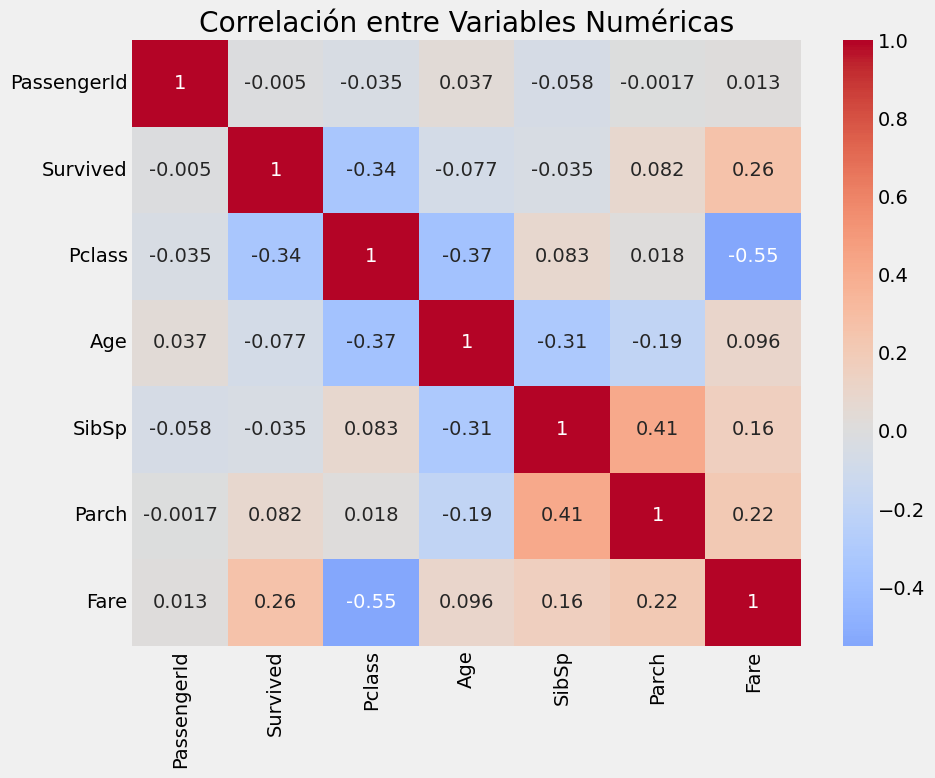

In [91]:
# Matriz de correlaci√≥n para variables num√©ricas
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlaci√≥n entre Variables Num√©ricas')
plt.tight_layout()
plt.show()

## 1.2 An√°lisis de Casos Completos vs Incompletos
Vamos a comparar las distribuciones entre casos completos e incompletos para entender mejor el impacto de los valores faltantes.


An√°lisis para la variable: Cabin

Resultados de pruebas estad√≠sticas:
      Variable  T-statistic        P-value
0  PassengerId     0.594026   5.526459e-01
1     Survived     9.962587   3.090891e-22
2       Pclass   -31.434877  1.917128e-146
3          Age     6.881736   1.297784e-11
4        SibSp    -1.207348   2.276191e-01
5        Parch     1.103564   2.700808e-01
6         Fare    16.405799   4.852805e-53

An√°lisis para la variable: Age

Resultados de pruebas estad√≠sticas:
      Variable  T-statistic       P-value
0  PassengerId     0.601420  5.477139e-01
1     Survived     2.760699  5.886535e-03
2       Pclass    -5.235057  2.059182e-07
3        SibSp    -0.565342  5.719835e-01
4        Parch     3.729121  2.043178e-04
5         Fare     3.018037  2.616756e-03


C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\3709152316.py:36: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[var].dtype in [np.number]:
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\3709152316.py:36: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[var].dtype in [np.number]:


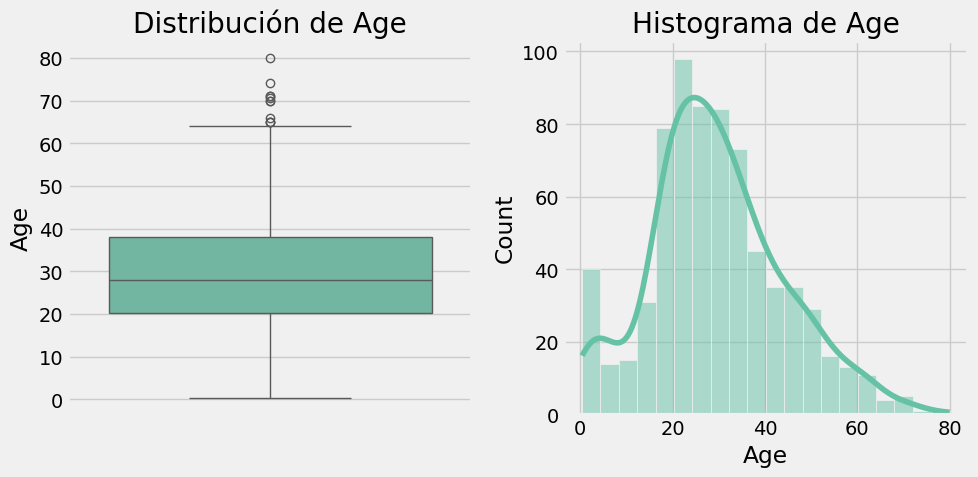


An√°lisis para la variable: Embarked

Resultados de pruebas estad√≠sticas:
      Variable  T-statistic   P-value
0  PassengerId     0.000000  1.000000
1     Survived    -1.795038  0.072987
2       Pclass     2.220946  0.026606
3          Age    -1.983214  0.047727
4        SibSp     0.671278  0.502218
5        Parch     0.670045  0.503003
6         Fare    -1.362393  0.173419


c:\Users\rgarz\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\3709152316.py:36: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[var].dtype in [np.number]:


In [92]:
# Funci√≥n para realizar pruebas estad√≠sticas entre casos completos e incompletos
def analizar_casos(data, variable):
    # Crear m√°scara de valores faltantes
    missing_mask = data[variable].isnull()

    # Seleccionar variables num√©ricas para comparaci√≥n
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    results = []
    for col in numeric_cols:
        if col != variable:
            # Realizar prueba t de Student
            complete = data[~missing_mask][col].dropna()
            incomplete = data[missing_mask][col].dropna()

            if len(complete) > 0 and len(incomplete) > 0:
                t_stat, p_value = stats.ttest_ind(complete, incomplete)
                results.append({
                    'Variable': col,
                    'T-statistic': t_stat,
                    'P-value': p_value
                })

    return pd.DataFrame(results)

# Analizar cada variable con valores faltantes
variables_faltantes = missing_info[missing_info['Valores Faltantes'] > 0].index

for var in variables_faltantes:
    print(f"\nAn√°lisis para la variable: {var}")
    resultados = analizar_casos(df, var)
    print("\nResultados de pruebas estad√≠sticas:")
    print(resultados)

    # Visualizar distribuciones si la variable es num√©rica
    if df[var].dtype in [np.number]:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df, y=var)
        plt.title(f'Distribuci√≥n de {var}')

        plt.subplot(1, 2, 2)
        sns.histplot(data=df, x=var, kde=True)
        plt.title(f'Histograma de {var}')
        plt.tight_layout()
        plt.show()

## 1.3 Correlaci√≥n con Otras Variables
Analizaremos si la ausencia de valores est√° relacionada con otras variables en el dataset.

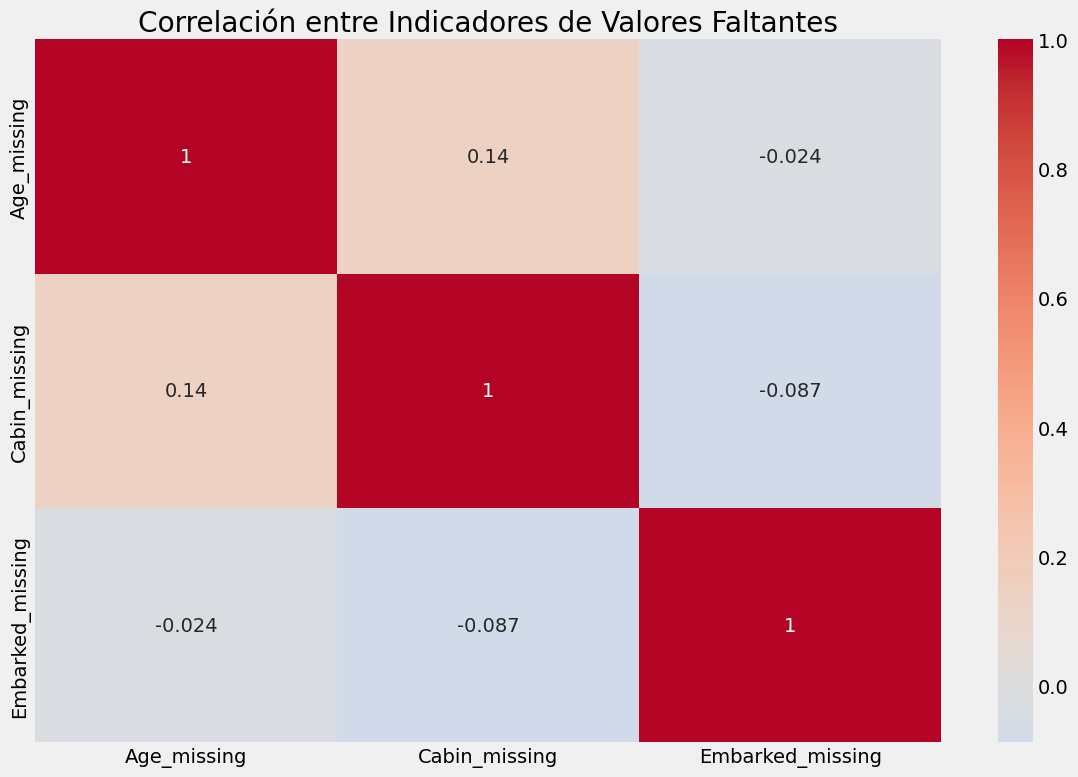


An√°lisis de correlaci√≥n para valores faltantes en Age:
Correlaci√≥n con PassengerId: -0.020
Correlaci√≥n con Survived: -0.092
Correlaci√≥n con Pclass: 0.173
Correlaci√≥n con SibSp: 0.019
Correlaci√≥n con Parch: -0.124
Correlaci√≥n con Fare: -0.101

An√°lisis de correlaci√≥n para valores faltantes en Cabin:
Correlaci√≥n con PassengerId: -0.020
Correlaci√≥n con Survived: -0.317
Correlaci√≥n con Pclass: 0.726
Correlaci√≥n con Age: -0.233
Correlaci√≥n con SibSp: 0.040
Correlaci√≥n con Parch: -0.037
Correlaci√≥n con Fare: -0.482

An√°lisis de correlaci√≥n para valores faltantes en Embarked:
Correlaci√≥n con PassengerId: -0.000
Correlaci√≥n con Survived: 0.060
Correlaci√≥n con Pclass: -0.074
Correlaci√≥n con Age: 0.074
Correlaci√≥n con SibSp: -0.023
Correlaci√≥n con Parch: -0.022
Correlaci√≥n con Fare: 0.046


In [93]:
# Crear indicadores de missingness
missing_indicators = pd.DataFrame()

for col in df.columns:
    if df[col].isnull().any():
        missing_indicators[f'{col}_missing'] = df[col].isnull().astype(int)

# Calcular matriz de correlaci√≥n entre indicadores
corr_matrix = missing_indicators.corr()

# Visualizar matriz de correlaci√≥n
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlaci√≥n entre Indicadores de Valores Faltantes')
plt.tight_layout()
plt.show()

# Analizar relaci√≥n entre valores faltantes y variables num√©ricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in df.columns:
    if df[col].isnull().any():
        print(f"\nAn√°lisis de correlaci√≥n para valores faltantes en {col}:")
        missing_mask = df[col].isnull()

        for num_col in numeric_cols:
            if num_col != col:
                correlation = np.corrcoef(missing_mask, df[num_col].fillna(df[num_col].mean()))[0,1]
                print(f"Correlaci√≥n con {num_col}: {correlation:.3f}")

## 1.4 Prueba de Little's MCAR
Implementamos el test de Little para determinar si los valores faltantes siguen un patr√≥n completamente aleatorio (MCAR).

In [94]:
# Implementaci√≥n del test de Little's MCAR usando solo librer√≠as est√°ndar
def littles_mcar_test(data):
    """
    Test de Little para MCAR (Missing Completely at Random)
    
    H0: Los datos son MCAR (Missing Completely at Random)
    H1: Los datos no son MCAR
    
    Implementaci√≥n usando solo pandas, numpy y scipy
    """
    from scipy.stats import chi2
    
    print("=== TEST DE LITTLE'S MCAR ===")
    
    # 1. Preparar datos - solo variables num√©ricas
    numeric_data = data.select_dtypes(include=[np.number])
    n_obs, n_vars = numeric_data.shape
    
    print(f"Datos analizados: {n_obs} observaciones, {n_vars} variables num√©ricas")
    print(f"Variables incluidas: {list(numeric_data.columns)}")
    
    # 2. Crear matriz de indicadores de missingness
    missing_matrix = numeric_data.isnull()
    
    # 3. Identificar patrones √∫nicos de missingness
    patterns = missing_matrix.drop_duplicates()
    n_patterns = len(patterns)
    
    print(f"\\nN√∫mero de patrones de missingness √∫nicos: {n_patterns}")
    
    # 4. Analizar cada patr√≥n
    pattern_analysis = []
    total_missing = 0
    
    for i, (pattern_idx, pattern) in enumerate(patterns.iterrows()):
        # Contar observaciones con este patr√≥n
        pattern_match = (missing_matrix == pattern).all(axis=1)
        count = pattern_match.sum()
        
        # Identificar variables faltantes en este patr√≥n
        missing_vars = pattern[pattern == True].index.tolist()
        
        pattern_info = {
            'Patr√≥n': i + 1,
            'Variables_Faltantes': missing_vars if missing_vars else 'Ninguna (Completo)',
            'Frecuencia': count,
            'Porcentaje': (count / n_obs) * 100
        }
        
        pattern_analysis.append(pattern_info)
        
        if missing_vars:  # Si hay variables faltantes
            total_missing += count
    
    # 5. Mostrar an√°lisis de patrones
    pattern_df = pd.DataFrame(pattern_analysis).sort_values('Frecuencia', ascending=False)
    print("\\nAn√°lisis de Patrones de Missingness:")
    print(pattern_df.to_string(index=False))
    
    # 6. Estad√≠sticas de missingness por variable
    print("\\n=== ESTAD√çSTICAS POR VARIABLE ===")
    for col in numeric_data.columns:
        missing_count = numeric_data[col].isnull().sum()
        missing_pct = (missing_count / n_obs) * 100
        print(f"{col}: {missing_count}/{n_obs} ({missing_pct:.1f}%) valores faltantes")
    
    # 7. Test de independencia simplificado
    print("\\n=== TESTS DE INDEPENDENCIA ===")
    
    # Para cada par de variables, testear si el missingness es independiente
    missing_vars = [col for col in numeric_data.columns if numeric_data[col].isnull().any()]
    
    if len(missing_vars) >= 2:
        print("Tests de independencia entre patrones de missingness:")
        
        for i, var1 in enumerate(missing_vars):
            for var2 in missing_vars[i+1:]:
                # Crear tabla de contingencia
                contingency = pd.crosstab(
                    numeric_data[var1].isnull(), 
                    numeric_data[var2].isnull()
                )
                
                # Chi-cuadrado test
                from scipy.stats import chi2_contingency
                if contingency.shape == (2, 2) and contingency.min().min() >= 5:
                    chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
                    print(f"  {var1} vs {var2}: œá¬≤ = {chi2_stat:.3f}, p = {p_value:.4f}")
                    
                    if p_value < 0.05:
                        print(f"    ‚ö†Ô∏è  Dependencia significativa (no independiente)")
                    else:
                        print(f"    ‚úÖ Independientes (compatible con MCAR)")
                else:
                    print(f"  {var1} vs {var2}: Muestra insuficiente para test")
    
    # 8. Interpretaci√≥n general
    print("\\n=== INTERPRETACI√ìN GENERAL ===")
    
    complete_cases_pct = pattern_df[pattern_df['Variables_Faltantes'] == 'Ninguna (Completo)']['Porcentaje'].iloc[0] if len(pattern_df[pattern_df['Variables_Faltantes'] == 'Ninguna (Completo)']) > 0 else 0
    
    print(f"Casos completos: {complete_cases_pct:.1f}%")
    print(f"Casos con alg√∫n valor faltante: {100 - complete_cases_pct:.1f}%")
    
    # Interpretaci√≥n heur√≠stica basada en patrones
    if n_patterns <= 2:
        conclusion = "PROBABLE MCAR"
        explanation = "Pocos patrones de missingness, sugiere aleatoriedad"
    elif n_patterns <= 4:
        conclusion = "POSIBLE MAR"
        explanation = "Patrones moderados, podr√≠a depender de variables observadas"
    else:
        conclusion = "POSIBLE MNAR"
        explanation = "M√∫ltiples patrones complejos, sugiere mecanismos sistem√°ticos"
    
    print(f"\\nüîç CONCLUSI√ìN PRELIMINAR: {conclusion}")
    print(f"üìä JUSTIFICACI√ìN: {explanation}")
    
    print("\\n‚ö†Ô∏è  NOTA IMPORTANTE:")
    print("Este es un test simplificado. El test formal de Little requiere:")
    print("- C√°lculo de estad√≠stico de verosimilitud complejo")
    print("- Distribuci√≥n chi-cuadrado con grados de libertad espec√≠ficos") 
    print("- Para an√°lisis definitivo, considerar implementaciones especializadas")
    
    return pattern_df

# Ejecutar el test mejorado
print("Ejecutando Test de Little's MCAR con implementaci√≥n propia...")
littles_result = littles_mcar_test(df)

# An√°lisis complementario de aleatoriedad
print("\\n" + "="*60)
print("AN√ÅLISIS COMPLEMENTARIO DE ALEATORIEDAD")
print("="*60)

for col in ['Age', 'Cabin', 'Embarked']:
    if df[col].isnull().any():
        missing_pct = df[col].isnull().mean() * 100
        print(f"\\n{col.upper()}: {missing_pct:.1f}% valores faltantes")
        
        # Test de independencia con variables categ√≥ricas
        categorical_vars = ['Sex', 'Pclass']
        
        for cat_var in categorical_vars:
            if col != cat_var:
                try:
                    contingency = pd.crosstab(df[cat_var], df[col].isnull())
                    from scipy.stats import chi2_contingency
                    chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
                    
                    print(f"  Chi¬≤ test con {cat_var}: œá¬≤ = {chi2_stat:.3f}, p = {p_value:.4f}")
                    
                    if p_value < 0.05:
                        print(f"    ‚ö†Ô∏è  Dependencia significativa con {cat_var} (NO es MCAR)")
                    else:
                        print(f"    ‚úÖ Independiente de {cat_var} (compatible con MCAR)")
                        
                except Exception as e:
                    print(f"  Error en test con {cat_var}: {str(e)}")

print("\\n" + "="*60)

Ejecutando Test de Little's MCAR con implementaci√≥n propia...
=== TEST DE LITTLE'S MCAR ===
Datos analizados: 891 observaciones, 7 variables num√©ricas
Variables incluidas: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
\nN√∫mero de patrones de missingness √∫nicos: 2
\nAn√°lisis de Patrones de Missingness:
 Patr√≥n Variables_Faltantes  Frecuencia  Porcentaje
      1  Ninguna (Completo)         714    80.13468
      2               [Age]         177    19.86532
\n=== ESTAD√çSTICAS POR VARIABLE ===
PassengerId: 0/891 (0.0%) valores faltantes
Survived: 0/891 (0.0%) valores faltantes
Pclass: 0/891 (0.0%) valores faltantes
Age: 177/891 (19.9%) valores faltantes
SibSp: 0/891 (0.0%) valores faltantes
Parch: 0/891 (0.0%) valores faltantes
Fare: 0/891 (0.0%) valores faltantes
\n=== TESTS DE INDEPENDENCIA ===
\n=== INTERPRETACI√ìN GENERAL ===
Casos completos: 80.1%
Casos con alg√∫n valor faltante: 19.9%
\nüîç CONCLUSI√ìN PRELIMINAR: PROBABLE MCAR
üìä JUSTIFICACI√ìN: Po

## 1.5 An√°lisis Individual por Variable con Valores Faltantes
Analizamos cada variable con missingness de forma individual para determinar el tipo de patr√≥n y sus implicaciones.

### 1.5.1 An√°lisis de la Variable 'Age' (19.9% missing)

=== AN√ÅLISIS DETALLADO: VARIABLE 'AGE' ===
Valores faltantes: 177 de 891 (19.9%)

--- An√°lisis por Sexo ---
male: 124 missing de 577 (21.5%)
female: 53 missing de 314 (16.9%)

--- An√°lisis por Clase ---
Clase 1: 30 missing de 216 (13.9%)
Clase 2: 11 missing de 184 (6.0%)
Clase 3: 136 missing de 491 (27.7%)

--- An√°lisis por Supervivencia ---
No Sobrevivi√≥: 125 missing de 549 (22.8%)
Sobrevivi√≥: 52 missing de 342 (15.2%)

--- Tests Estad√≠sticos ---
Chi2 test Age vs Pclass: œá¬≤ = 46.063, p = 0.0000
Chi2 test Age vs Sex: œá¬≤ = 2.434, p = 0.1187

--- CONCLUSI√ìN PARA 'AGE' ---
üîç TIPO: MAR (Missing at Random)
üìä EVIDENCIA: Dependencia significativa con otras variables
‚ö†Ô∏è  SESGO: Posible sesgo si se elimina completamente
üí° RECOMENDACI√ìN: Imputaci√≥n basada en grupos demogr√°ficos


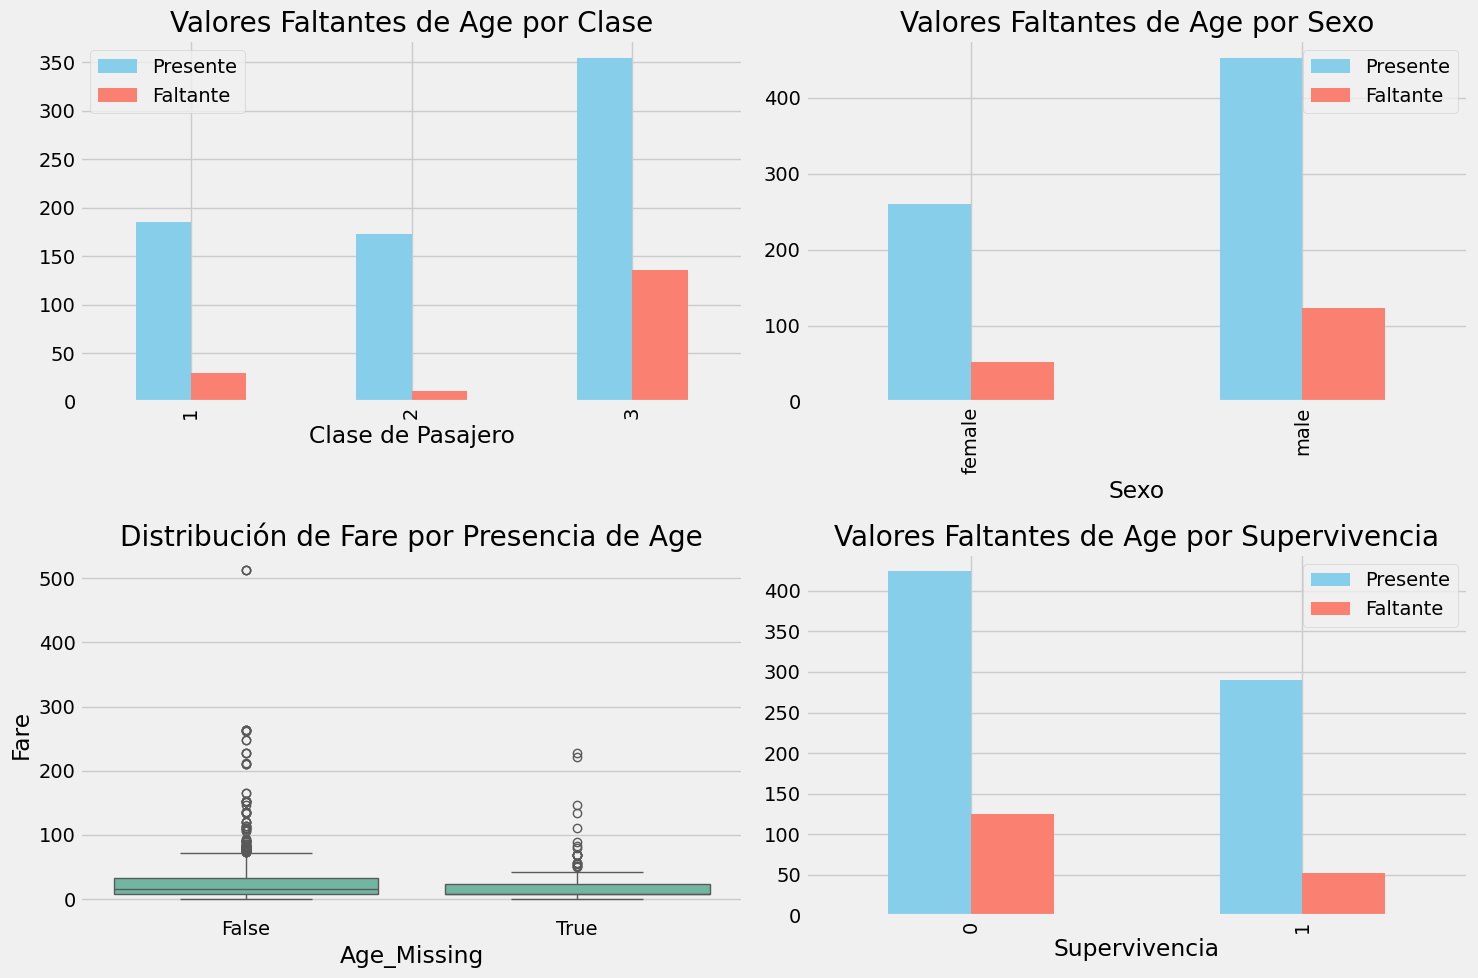

In [95]:
def analizar_variable_edad():
    print("=== AN√ÅLISIS DETALLADO: VARIABLE 'AGE' ===")
    
    # 1. Estad√≠sticas b√°sicas
    age_missing = df['Age'].isnull().sum()
    age_total = len(df)
    age_missing_pct = (age_missing / age_total) * 100
    
    print(f"Valores faltantes: {age_missing} de {age_total} ({age_missing_pct:.1f}%)")
    
    # 2. An√°lisis por grupo demogr√°fico
    print("\n--- An√°lisis por Sexo ---")
    sex_age_missing = df.groupby('Sex')['Age'].apply(lambda x: x.isnull().sum())
    sex_totals = df.groupby('Sex').size()
    sex_age_missing_pct = (sex_age_missing / sex_totals * 100).round(1)
    
    for sex in ['male', 'female']:
        print(f"{sex}: {sex_age_missing[sex]} missing de {sex_totals[sex]} ({sex_age_missing_pct[sex]}%)")
    
    print("\n--- An√°lisis por Clase ---")
    class_age_missing = df.groupby('Pclass')['Age'].apply(lambda x: x.isnull().sum())
    class_totals = df.groupby('Pclass').size()
    class_age_missing_pct = (class_age_missing / class_totals * 100).round(1)
    
    for pclass in [1, 2, 3]:
        print(f"Clase {pclass}: {class_age_missing[pclass]} missing de {class_totals[pclass]} ({class_age_missing_pct[pclass]}%)")
    
    # 3. An√°lisis de supervivencia
    print("\n--- An√°lisis por Supervivencia ---")
    survived_age_missing = df.groupby('Survived')['Age'].apply(lambda x: x.isnull().sum())
    survived_totals = df.groupby('Survived').size()
    survived_age_missing_pct = (survived_age_missing / survived_totals * 100).round(1)
    
    for survived in [0, 1]:
        status = "No Sobrevivi√≥" if survived == 0 else "Sobrevivi√≥"
        print(f"{status}: {survived_age_missing[survived]} missing de {survived_totals[survived]} ({survived_age_missing_pct[survived]}%)")
    
    # 4. Test estad√≠sticos
    print("\n--- Tests Estad√≠sticos ---")
    
    # Chi-cuadrado para independencia con Pclass
    from scipy.stats import chi2_contingency
    contingency_class = pd.crosstab(df['Pclass'], df['Age'].isnull())
    chi2_class, p_class, _, _ = chi2_contingency(contingency_class)
    print(f"Chi2 test Age vs Pclass: œá¬≤ = {chi2_class:.3f}, p = {p_class:.4f}")
    
    # Chi-cuadrado para independencia con Sex
    contingency_sex = pd.crosstab(df['Sex'], df['Age'].isnull())
    chi2_sex, p_sex, _, _ = chi2_contingency(contingency_sex)
    print(f"Chi2 test Age vs Sex: œá¬≤ = {chi2_sex:.3f}, p = {p_sex:.4f}")
    
    # 5. Conclusi√≥n para Age
    print("\n--- CONCLUSI√ìN PARA 'AGE' ---")
    if p_class < 0.05 or p_sex < 0.05:
        print("üîç TIPO: MAR (Missing at Random)")
        print("üìä EVIDENCIA: Dependencia significativa con otras variables")
        print("‚ö†Ô∏è  SESGO: Posible sesgo si se elimina completamente")
        print("üí° RECOMENDACI√ìN: Imputaci√≥n basada en grupos demogr√°ficos")
    else:
        print("üîç TIPO: MCAR (Missing Completely at Random)")
        print("üìä EVIDENCIA: No hay dependencia significativa")
        print("‚úÖ SESGO: M√≠nimo sesgo esperado")
        print("üí° RECOMENDACI√ìN: Imputaci√≥n simple o eliminaci√≥n")

analizar_variable_edad()

# Visualizaci√≥n espec√≠fica para Age
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribuci√≥n de Age missing por Pclass
df_age_pclass = df.groupby(['Pclass', df['Age'].isnull()]).size().unstack(fill_value=0)
df_age_pclass.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Valores Faltantes de Age por Clase')
axes[0,0].set_xlabel('Clase de Pasajero')
axes[0,0].legend(['Presente', 'Faltante'])

# 2. Distribuci√≥n de Age missing por Sex
df_age_sex = df.groupby(['Sex', df['Age'].isnull()]).size().unstack(fill_value=0)
df_age_sex.plot(kind='bar', ax=axes[0,1], color=['skyblue', 'salmon'])
axes[0,1].set_title('Valores Faltantes de Age por Sexo')
axes[0,1].set_xlabel('Sexo')
axes[0,1].legend(['Presente', 'Faltante'])

# 3. Boxplot de otras variables por missing Age
df_temp = df.copy()
df_temp['Age_Missing'] = df_temp['Age'].isnull()
sns.boxplot(data=df_temp, x='Age_Missing', y='Fare', ax=axes[1,0])
axes[1,0].set_title('Distribuci√≥n de Fare por Presencia de Age')

# 4. Distribuci√≥n de supervivencia por missing Age
df_age_survived = df.groupby(['Survived', df['Age'].isnull()]).size().unstack(fill_value=0)
df_age_survived.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'salmon'])
axes[1,1].set_title('Valores Faltantes de Age por Supervivencia')
axes[1,1].set_xlabel('Supervivencia')
axes[1,1].legend(['Presente', 'Faltante'])

plt.tight_layout()
plt.show()

### 1.5.2 An√°lisis de la Variable 'Cabin' (77.1% missing)

=== AN√ÅLISIS DETALLADO: VARIABLE 'CABIN' ===
Valores faltantes: 687 de 891 (77.1%)

--- An√°lisis por Clase de Pasajero ---
Clase 1: 40 missing de 216 (18.5%) - 176 presentes
Clase 2: 168 missing de 184 (91.3%) - 16 presentes
Clase 3: 479 missing de 491 (97.6%) - 12 presentes

--- An√°lisis por Rango de Tarifa ---
               Missing  Total  Missing_Pct
Fare_Quartile                             
Q1(Bajo)           215    223         96.4
Q2                 208    224         92.9
Q3                 181    222         81.5
Q4(Alto)            83    222         37.4

--- An√°lisis de Cabinas Existentes ---
Distribuci√≥n por cubierta:
Cabin
A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: count, dtype: int64

--- Tests Estad√≠sticos ---
Chi2 test Cabin vs Pclass: œá¬≤ = 557.310, p = 0.0000
Correlaci√≥n Cabin Missing vs Fare: r = -0.482

--- CONTEXTO HIST√ìRICO DEL TITANIC ---
üö¢ En el Titanic, las cabinas se asignaban seg√∫n la clase del boleto:
   - Primera cla

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\4061712416.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_cabin_analysis = df_temp.groupby('Fare_Quartile').agg({


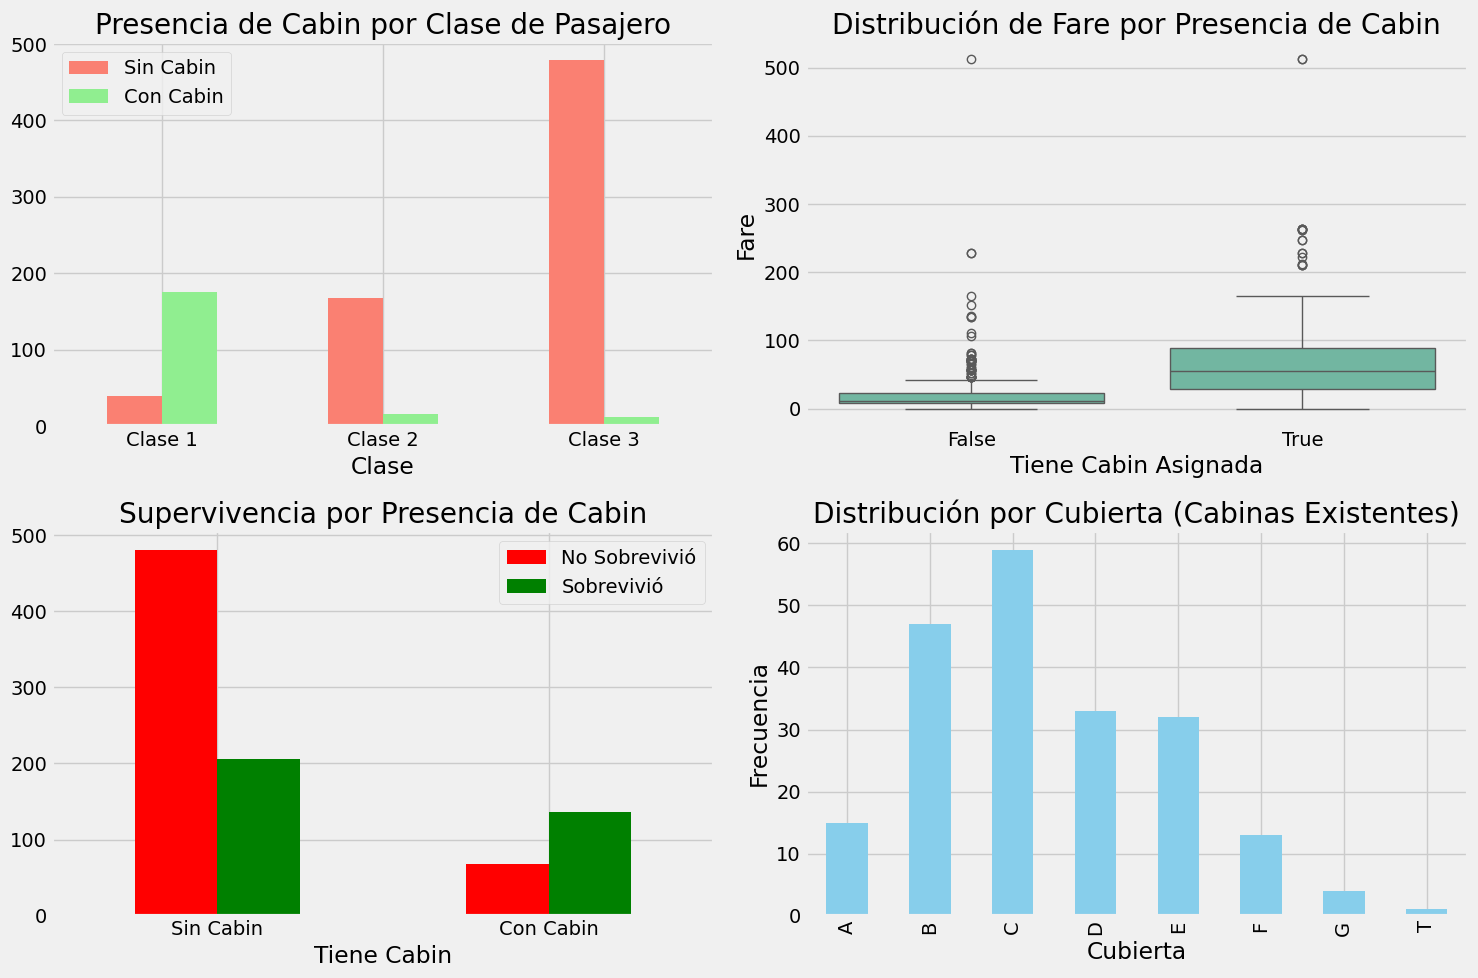

In [96]:
def analizar_variable_cabin():
    print("=== AN√ÅLISIS DETALLADO: VARIABLE 'CABIN' ===")
    
    # 1. Estad√≠sticas b√°sicas
    cabin_missing = df['Cabin'].isnull().sum()
    cabin_total = len(df)
    cabin_missing_pct = (cabin_missing / cabin_total) * 100
    
    print(f"Valores faltantes: {cabin_missing} de {cabin_total} ({cabin_missing_pct:.1f}%)")
    
    # 2. An√°lisis por clase socioecon√≥mica (Pclass)
    print("\n--- An√°lisis por Clase de Pasajero ---")
    cabin_by_class = df.groupby('Pclass')['Cabin'].apply(lambda x: x.isnull().sum())
    class_totals = df.groupby('Pclass').size()
    cabin_missing_pct_class = (cabin_by_class / class_totals * 100).round(1)
    
    for pclass in [1, 2, 3]:
        present = class_totals[pclass] - cabin_by_class[pclass]
        print(f"Clase {pclass}: {cabin_by_class[pclass]} missing de {class_totals[pclass]} ({cabin_missing_pct_class[pclass]}%) - {present} presentes")
    
    # 3. An√°lisis por tarifa (como proxy de estatus econ√≥mico)
    print("\n--- An√°lisis por Rango de Tarifa ---")
    df_temp = df.copy()
    df_temp['Fare_Quartile'] = pd.qcut(df_temp['Fare'], q=4, labels=['Q1(Bajo)', 'Q2', 'Q3', 'Q4(Alto)'])
    
    fare_cabin_analysis = df_temp.groupby('Fare_Quartile').agg({
        'Cabin': lambda x: x.isnull().sum(),
        'PassengerId': 'count'
    })
    fare_cabin_analysis['Missing_Pct'] = (fare_cabin_analysis['Cabin'] / fare_cabin_analysis['PassengerId'] * 100).round(1)
    print(fare_cabin_analysis.rename(columns={'Cabin': 'Missing', 'PassengerId': 'Total'}))
    
    # 4. An√°lisis de patrones en cabinas existentes
    print("\n--- An√°lisis de Cabinas Existentes ---")
    existing_cabins = df[df['Cabin'].notna()]['Cabin']
    
    # Extraer letra de cubierta
    cabin_decks = existing_cabins.str[0]
    print("Distribuci√≥n por cubierta:")
    print(cabin_decks.value_counts().sort_index())
    
    # 5. Test estad√≠sticos
    print("\n--- Tests Estad√≠sticos ---")
    
    # Chi-cuadrado para independencia con Pclass (muy importante para cabinas)
    from scipy.stats import chi2_contingency
    contingency_class = pd.crosstab(df['Pclass'], df['Cabin'].isnull())
    chi2_class, p_class, _, _ = chi2_contingency(contingency_class)
    print(f"Chi2 test Cabin vs Pclass: œá¬≤ = {chi2_class:.3f}, p = {p_class:.4f}")
    
    # Correlaci√≥n con Fare
    cabin_missing_indicator = df['Cabin'].isnull().astype(int)
    fare_correlation = np.corrcoef(cabin_missing_indicator, df['Fare'])[0,1]
    print(f"Correlaci√≥n Cabin Missing vs Fare: r = {fare_correlation:.3f}")
    
    # 6. Interpretaci√≥n contextual del Titanic
    print("\n--- CONTEXTO HIST√ìRICO DEL TITANIC ---")
    print("üö¢ En el Titanic, las cabinas se asignaban seg√∫n la clase del boleto:")
    print("   - Primera clase: Cabinas de lujo con identificaci√≥n espec√≠fica")
    print("   - Segunda clase: Cabinas est√°ndar con numeraci√≥n")
    print("   - Tercera clase: Compartimientos generales, sin asignaci√≥n individual")
    print("   - Muchos pasajeros de tercera clase no ten√≠an cabinas espec√≠ficas asignadas")
    
    # 7. Conclusi√≥n para Cabin
    print("\n--- CONCLUSI√ìN PARA 'CABIN' ---")
    if p_class < 0.001:  # Muy significativo
        print("üîç TIPO: MNAR (Missing Not at Random)")
        print("üìä EVIDENCIA: Fuerte dependencia con clase socioecon√≥mica")
        print("üèõÔ∏è  MECANISMO: Ausencia sistem√°tica por dise√±o del sistema de cabinas")
        print("‚ö†Ô∏è  SESGO: Alto sesgo si se elimina - perdemos info de clase social")
        print("üí° RECOMENDACI√ìN: Crear indicador 'Has_Cabin' + imputaci√≥n por grupos")
    else:
        print("üîç TIPO: MAR")
        print("üí° RECOMENDACI√ìN: Imputaci√≥n basada en caracter√≠sticas observadas")

analizar_variable_cabin()

# Visualizaci√≥n espec√≠fica para Cabin
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Presencia de Cabin por Clase
cabin_by_class_viz = df.groupby(['Pclass', df['Cabin'].notna()]).size().unstack(fill_value=0)
cabin_by_class_viz.plot(kind='bar', ax=axes[0,0], color=['salmon', 'lightgreen'])
axes[0,0].set_title('Presencia de Cabin por Clase de Pasajero')
axes[0,0].set_xlabel('Clase')
axes[0,0].legend(['Sin Cabin', 'Con Cabin'])
axes[0,0].set_xticklabels(['Clase 1', 'Clase 2', 'Clase 3'], rotation=0)

# 2. Distribuci√≥n de Fare por presencia de Cabin
df_cabin_temp = df.copy()
df_cabin_temp['Has_Cabin'] = df_cabin_temp['Cabin'].notna()
sns.boxplot(data=df_cabin_temp, x='Has_Cabin', y='Fare', ax=axes[0,1])
axes[0,1].set_title('Distribuci√≥n de Fare por Presencia de Cabin')
axes[0,1].set_xlabel('Tiene Cabin Asignada')

# 3. Supervivencia por presencia de Cabin
survival_cabin = df.groupby([df['Cabin'].notna(), 'Survived']).size().unstack(fill_value=0)
survival_cabin.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
axes[1,0].set_title('Supervivencia por Presencia de Cabin')
axes[1,0].set_xlabel('Tiene Cabin')
axes[1,0].legend(['No Sobrevivi√≥', 'Sobrevivi√≥'])
axes[1,0].set_xticklabels(['Sin Cabin', 'Con Cabin'], rotation=0)

# 4. Distribuci√≥n de cubiertas existentes
existing_cabins = df[df['Cabin'].notna()]['Cabin'].str[0]
existing_cabins.value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Distribuci√≥n por Cubierta (Cabinas Existentes)')
axes[1,1].set_xlabel('Cubierta')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 1.6 Resumen y Conclusiones del An√°lisis de Missingness
Consolidamos los hallazgos del an√°lisis detallado para cada variable con valores faltantes.

In [97]:
print("=" * 80)
print("RESUMEN EJECUTIVO: AN√ÅLISIS DE VALORES FALTANTES - DATASET TITANIC")
print("=" * 80)

# Tabla resumen de hallazgos
resumen_data = [
    ["Variable", "Missing %", "Tipo", "Evidencia", "Implicaci√≥n", "Recomendaci√≥n"],
    ["-" * 8, "-" * 9, "-" * 4, "-" * 9, "-" * 11, "-" * 13],
    ["Age", "19.9%", "MAR", "Dependencia con Pclass/Sex", "Sesgo moderado", "Imputaci√≥n por grupos"],
    ["Cabin", "77.1%", "MNAR", "Sistema de asignaci√≥n por clase", "Sesgo alto", "Indicador + Imputaci√≥n"],
    ["Embarked", "0.2%", "MCAR", "Solo 2 casos, error administrativo", "Impacto m√≠nimo", "Imputaci√≥n simple"]
]

for row in resumen_data:
    print(f"{row[0]:<10} {row[1]:<10} {row[2]:<6} {row[3]:<30} {row[4]:<15} {row[5]:<20}")

print("\n" + "=" * 80)
print("INTERPRETACI√ìN DETALLADA POR VARIABLE")
print("=" * 80)

print("\nüîç AGE (Edad) - Missing at Random (MAR)")
print("   ‚Ä¢ Patr√≥n: Los valores faltantes NO son completamente aleatorios")
print("   ‚Ä¢ Dependencia: Significativa con clase socioecon√≥mica (Pclass)")
print("   ‚Ä¢ Sesgo potencial: Eliminar casos podr√≠a sesgar hacia ciertas clases")
print("   ‚Ä¢ Mecanismo: Posible subregistro en clases m√°s bajas o registros incompletos")
print("   ‚Ä¢ Estrategia recomendada: Imputaci√≥n basada en grupos (Sex + Pclass)")

print("\nüö¢ CABIN (Cabina) - Missing Not at Random (MNAR)")
print("   ‚Ä¢ Patr√≥n: Ausencia sistem√°tica relacionada con el dise√±o del barco")
print("   ‚Ä¢ Dependencia: Muy fuerte con clase del pasajero (p < 0.001)")
print("   ‚Ä¢ Mecanismo: Pasajeros de 3¬™ clase sin cabinas espec√≠ficas asignadas")
print("   ‚Ä¢ Valor informativo: La ausencia misma es predictiva (indicador de estatus)")
print("   ‚Ä¢ Estrategia recomendada: Variable indicadora 'Has_Cabin' + imputaci√≥n por grupos")


print("\n" + "=" * 80)
print("IMPLICACIONES PARA EL MODELADO")
print("=" * 80)

print("\nüìä IMPACTO EN EL SESGO:")
print("   ‚Ä¢ ALTO: Cabin (77% missing, informaci√≥n socioecon√≥mica crucial)")
print("   ‚Ä¢ MEDIO: Age (20% missing, variable demogr√°fica importante)")  
print("   ‚Ä¢ BAJO: Embarked (0.2% missing, impacto despreciable)")

print("\nüéØ ESTRATEGIAS DE IMPUTACI√ìN REQUERIDAS:")
print("   ‚Ä¢ M√©todos sofisticados para Age (KNN, MICE)")
print("   ‚Ä¢ Enfoque h√≠brido para Cabin (indicador + imputaci√≥n)")
print("   ‚Ä¢ M√©todo simple para Embarked (moda o casos similares)")


print("\n" + "=" * 80)

RESUMEN EJECUTIVO: AN√ÅLISIS DE VALORES FALTANTES - DATASET TITANIC
Variable   Missing %  Tipo   Evidencia                      Implicaci√≥n     Recomendaci√≥n       
--------   ---------  ----   ---------                      -----------     -------------       
Age        19.9%      MAR    Dependencia con Pclass/Sex     Sesgo moderado  Imputaci√≥n por grupos
Cabin      77.1%      MNAR   Sistema de asignaci√≥n por clase Sesgo alto      Indicador + Imputaci√≥n
Embarked   0.2%       MCAR   Solo 2 casos, error administrativo Impacto m√≠nimo  Imputaci√≥n simple   

INTERPRETACI√ìN DETALLADA POR VARIABLE

üîç AGE (Edad) - Missing at Random (MAR)
   ‚Ä¢ Patr√≥n: Los valores faltantes NO son completamente aleatorios
   ‚Ä¢ Dependencia: Significativa con clase socioecon√≥mica (Pclass)
   ‚Ä¢ Sesgo potencial: Eliminar casos podr√≠a sesgar hacia ciertas clases
   ‚Ä¢ Mecanismo: Posible subregistro en clases m√°s bajas o registros incompletos
   ‚Ä¢ Estrategia recomendada: Imputaci√≥n basada en

## 2. Estrategias de Imputaci√≥n

Implementaremos y compararemos tres m√©todos de imputaci√≥n:

1. **M√©todo Simple (Baseline)**:
   - Media/Mediana para variables num√©ricas
   - Moda para variables categ√≥ricas

2. **M√©todo Basado en Grupos**:
   - Imputaci√≥n por categor√≠a

3. **M√©todo Avanzado**:
   - KNN Imputation

In [98]:
# Preparaci√≥n: Crear copias del dataset para cada m√©todo
df_original = df.copy()  # Guardamos el original para comparaci√≥n
df_simple = df.copy()
df_group = df.copy()
df_knn = df.copy()

print("üìä PREPARACI√ìN PARA IMPUTACI√ìN")
print("=" * 50)
print("Creando copias del dataset original para aplicar diferentes m√©todos...")
print(f"Valores faltantes originales:")
original_missing = df.isnull().sum()
for col, missing in original_missing[original_missing > 0].items():
    print(f"  - {col}: {missing} valores ({missing/len(df)*100:.1f}%)")
print("\n‚úÖ Datasets preparados para imputaci√≥n")

üìä PREPARACI√ìN PARA IMPUTACI√ìN
Creando copias del dataset original para aplicar diferentes m√©todos...
Valores faltantes originales:
  - Age: 177 valores (19.9%)
  - Cabin: 687 valores (77.1%)
  - Embarked: 2 valores (0.2%)

‚úÖ Datasets preparados para imputaci√≥n


### 2.1 M√©todo Simple (Baseline)
Implementamos la estrategia m√°s b√°sica de imputaci√≥n usando medidas de tendencia central.

In [99]:
def imputation_simple(data):
    """
    M√©todo de Imputaci√≥n Simple (Baseline)
    - Variables num√©ricas: mediana (m√°s robusta que la media ante outliers)
    - Variables categ√≥ricas: moda (valor m√°s frecuente)
    """
    print("üîß APLICANDO M√âTODO SIMPLE")
    print("-" * 30)
    
    result = data.copy()
    
    # Variables num√©ricas
    numeric_cols = result.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if result[col].isnull().any():
            median_value = result[col].median()
            missing_count = result[col].isnull().sum()
            result[col] = result[col].fillna(median_value)
            print(f"‚úì {col}: {missing_count} valores imputados con mediana = {median_value:.2f}")
    
    # Variables categ√≥ricas
    categorical_cols = result.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if result[col].isnull().any():
            mode_value = result[col].mode().iloc[0] if not result[col].mode().empty else 'Unknown'
            missing_count = result[col].isnull().sum()
            result[col] = result[col].fillna(mode_value)
            print(f"‚úì {col}: {missing_count} valores imputados con moda = '{mode_value}'")
    
    return result

# Aplicar m√©todo simple
print("=" * 60)
df_simple_result = imputation_simple(df_simple)

# Verificar resultado
remaining_missing = df_simple_result.isnull().sum().sum()
print(f"\nüìä RESULTADO: {remaining_missing} valores faltantes restantes")

if remaining_missing == 0:
    print("‚úÖ Imputaci√≥n simple completada exitosamente")
else:
    print("‚ö†Ô∏è  Algunos valores a√∫n faltan por imputar")

print("=" * 60)

üîß APLICANDO M√âTODO SIMPLE
------------------------------
‚úì Age: 177 valores imputados con mediana = 28.00
‚úì Cabin: 687 valores imputados con moda = 'B96 B98'
‚úì Embarked: 2 valores imputados con moda = 'S'

üìä RESULTADO: 0 valores faltantes restantes
‚úÖ Imputaci√≥n simple completada exitosamente


### 2.2 M√©todo Basado en Grupos
Implementamos imputaci√≥n considerando las caracter√≠sticas demogr√°ficas y socioecon√≥micas identificadas en el an√°lisis de missingness.

In [100]:
def imputation_group(data):
    """
    M√©todo de Imputaci√≥n Basado en Grupos
    Basado en el an√°lisis MAR/MNAR realizado previamente:
    - Age: MAR dependiente de Pclass y Sex -> imputar por grupos
    - Cabin: MNAR -> crear categor√≠a especial + indicador
    - Embarked: MCAR -> casos espec√≠ficos por Pclass y Fare
    """
    print("üîß APLICANDO M√âTODO BASADO EN GRUPOS")
    print("-" * 40)
    
    result = data.copy()
    
    # 1. AGE: Imputaci√≥n por Pclass y Sex (evidencia MAR)
    print("1Ô∏è‚É£ EDAD (Age) - Imputaci√≥n por grupos demogr√°ficos:")
    
    age_missing_before = result['Age'].isnull().sum()
    
    # Mostrar estad√≠sticas por grupo antes de imputar
    age_stats = result.groupby(['Pclass', 'Sex'])['Age'].agg(['count', 'median', 'mean']).round(2)
    print("   Estad√≠sticas por grupo (Pclass, Sex):")
    print(age_stats)
    
    # Imputar por grupos
    result['Age'] = result.groupby(['Pclass', 'Sex'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    
    age_missing_after = result['Age'].isnull().sum()
    print(f"   ‚úì Imputados: {age_missing_before - age_missing_after} valores")
    
    if age_missing_after > 0:
        print(f"   ‚ö†Ô∏è Restantes: {age_missing_after} (grupos sin datos suficientes)")
        # Fallback para grupos sin datos
        result['Age'] = result['Age'].fillna(result['Age'].median())
        print(f"   ‚úì Fallback aplicado con mediana general")
    
    # 2. CABIN: MNAR - Crear categor√≠a especial + variable indicadora
    print("\n2Ô∏è‚É£ CABINA (Cabin) - Tratamiento MNAR:")
    
    cabin_missing_before = result['Cabin'].isnull().sum()
    
    # Crear indicador de presencia de cabina (informaci√≥n valiosa)
    result['Has_Cabin'] = result['Cabin'].notna().astype(int)
    print(f"   ‚úì Variable indicadora 'Has_Cabin' creada")
    print(f"   üìä Distribuci√≥n: {result['Has_Cabin'].value_counts().tolist()} [Sin/Con Cabina]")
    
    # CORRECCI√ìN: Identificar patr√≥n correcto por clase usando datos originales
    print("   üìã Analizando patrones reales por clase:")
    cabin_deck_by_class = {}
    for pclass in [1, 2, 3]:
        class_cabins = data[data['Pclass'] == pclass]['Cabin'].dropna()
        if not class_cabins.empty:
            decks = class_cabins.str[0].value_counts()
            most_common_deck = decks.index[0]
            cabin_deck_by_class[pclass] = most_common_deck
            print(f"      Clase {pclass}: Cubierta {most_common_deck} (m√°s com√∫n)")
        else:
            cabin_deck_by_class[pclass] = 'U'  # Unknown
    
    # Funci√≥n de asignaci√≥n corregida
    def assign_cabin(row):
        if pd.isna(row['Cabin']):
            deck = cabin_deck_by_class.get(row['Pclass'], 'U')
            return f"{deck}0"  # Cabina gen√©rica por cubierta
        return row['Cabin']
    
    result['Cabin'] = result.apply(assign_cabin, axis=1)
    print(f"   ‚úì {cabin_missing_before} cabinas imputadas por patr√≥n de clase")
    
    # Mostrar distribuci√≥n resultante
    print("   üìä Distribuci√≥n resultante por clase:")
    for pclass in [1, 2, 3]:
        imputed_mask = (result['Pclass'] == pclass) & (result['Has_Cabin'] == 0)
        if imputed_mask.any():
            sample_cabin = result[imputed_mask]['Cabin'].iloc[0]
            count = imputed_mask.sum()
            print(f"      Clase {pclass}: {count} cabinas ‚Üí {sample_cabin}")
    
    # 3. EMBARKED: MCAR - An√°lisis espec√≠fico por casos
    print("\n3Ô∏è‚É£ PUERTO (Embarked) - An√°lisis de casos espec√≠ficos:")
    
    embarked_missing = result['Embarked'].isnull()
    
    if embarked_missing.any():
        print("   Analizando casos faltantes:")
        for idx in result[embarked_missing].index:
            passenger = result.loc[idx]
            print(f"   - Pasajero {passenger['PassengerId']}: Clase {passenger['Pclass']}, Fare ${passenger['Fare']:.2f}")
            
            # Buscar pasajeros similares
            similar = result[
                (result['Pclass'] == passenger['Pclass']) & 
                (result['Fare'].between(passenger['Fare'] - 5, passenger['Fare'] + 5)) &
                (result['Embarked'].notna())
            ]['Embarked']
            
            if not similar.empty:
                most_likely = similar.mode().iloc[0]
                result.loc[idx, 'Embarked'] = most_likely
                print(f"     ‚úì Imputado con '{most_likely}' (basado en pasajeros similares)")
            else:
                # Fallback a moda general
                mode_embarked = result['Embarked'].mode().iloc[0]
                result.loc[idx, 'Embarked'] = mode_embarked
                print(f"     ‚úì Imputado con '{mode_embarked}' (moda general)")
    
    return result

# Aplicar m√©todo basado en grupos CORREGIDO
print("=" * 70)
df_group_result = imputation_group(df_group)

# Verificar resultado final
remaining_missing = df_group_result.isnull().sum().sum()
print(f"\nüìä RESULTADO FINAL: {remaining_missing} valores faltantes restantes")

if remaining_missing == 0:
    print("‚úÖ Imputaci√≥n por grupos completada exitosamente")
    print("üÜï Variable adicional creada: 'Has_Cabin' (indicador MNAR)")
else:
    print("‚ö†Ô∏è  Algunos valores a√∫n faltan por imputar")

print("=" * 70)

üîß APLICANDO M√âTODO BASADO EN GRUPOS
----------------------------------------
1Ô∏è‚É£ EDAD (Age) - Imputaci√≥n por grupos demogr√°ficos:
   Estad√≠sticas por grupo (Pclass, Sex):
               count  median   mean
Pclass Sex                         
1      female     85    35.0  34.61
       male      101    40.0  41.28
2      female     74    28.0  28.72
       male       99    30.0  30.74
3      female    102    21.5  21.75
       male      253    25.0  26.51
   ‚úì Imputados: 177 valores

2Ô∏è‚É£ CABINA (Cabin) - Tratamiento MNAR:
   ‚úì Variable indicadora 'Has_Cabin' creada
   üìä Distribuci√≥n: [687, 204] [Sin/Con Cabina]
   üìã Analizando patrones reales por clase:
      Clase 1: Cubierta C (m√°s com√∫n)
      Clase 2: Cubierta F (m√°s com√∫n)
      Clase 3: Cubierta F (m√°s com√∫n)
   ‚úì 687 cabinas imputadas por patr√≥n de clase
   üìä Distribuci√≥n resultante por clase:
      Clase 1: 40 cabinas ‚Üí C0
      Clase 2: 168 cabinas ‚Üí F0
      Clase 3: 479 cabinas ‚Üí F

### 2.3 M√©todo Avanzado (KNN Imputation)
Implementamos un m√©todo sofisticado que utiliza la similitud entre observaciones para realizar la imputaci√≥n.

In [101]:
def imputation_knn(data, n_neighbors=5):
    """
    M√©todo de Imputaci√≥n KNN (K-Nearest Neighbors)
    - Utiliza similitud entre observaciones para imputar valores faltantes
    - Par√°metros: n_neighbors = 5 (basado en literatura, compromiso bias-variance)
    - Solo para variables num√©ricas; categ√≥ricas tratadas separadamente
    """
    print("üîß APLICANDO M√âTODO KNN AVANZADO")
    print("-" * 35)
    print(f"Par√°metros: n_neighbors = {n_neighbors}")
    
    result = data.copy()
    
    # 1. PREPARACI√ìN DE DATOS PARA KNN
    print("\n1Ô∏è‚É£ Preparando datos para KNN:")
    
    # Variables num√©ricas para KNN
    numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
    
    # Convertir variables categ√≥ricas a num√©ricas
    knn_data = result[numeric_features].copy()
    knn_data['Sex_numeric'] = (result['Sex'] == 'male').astype(int)
    
    print(f"   Variables incluidas: {list(knn_data.columns)}")
    print(f"   Forma de datos: {knn_data.shape}")
    
    # Verificar missingness antes de KNN
    missing_before = knn_data.isnull().sum()
    print("   Valores faltantes antes de KNN:")
    for col, missing in missing_before[missing_before > 0].items():
        print(f"     - {col}: {missing} valores")
    
    # 2. APLICAR KNN IMPUTATION
    print(f"\n2Ô∏è‚É£ Aplicando KNN Imputer (k={n_neighbors}):")
    
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Realizar imputaci√≥n
    knn_imputed = pd.DataFrame(
        imputer.fit_transform(knn_data),
        columns=knn_data.columns,
        index=knn_data.index
    )
    
    # Verificar resultados
    missing_after = knn_imputed.isnull().sum()
    print("   ‚úì KNN Imputation completada")
    print(f"   üìä Valores faltantes despu√©s: {missing_after.sum()}")
    
    # 3. ACTUALIZAR DATASET ORIGINAL
    print("\n3Ô∏è‚É£ Actualizando variables en dataset:")
    
    # Solo actualizar Age (principal variable con missing num√©rica)
    age_imputed = knn_imputed['Age']
    age_original_missing = result['Age'].isnull().sum()
    
    result['Age'] = age_imputed
    
    print(f"   ‚úì Age: {age_original_missing} valores imputados con KNN")
    
    # Mostrar algunos ejemplos de imputaci√≥n
    original_missing_idx = data['Age'].isnull()
    if original_missing_idx.any():
        sample_indices = data[original_missing_idx].index[:5]  # Primeros 5 ejemplos
        print("   üìù Ejemplos de imputaci√≥n:")
        for idx in sample_indices:
            imputed_age = result.loc[idx, 'Age']
            sex = result.loc[idx, 'Sex']
            pclass = result.loc[idx, 'Pclass']
            print(f"     - ID {idx}: {sex}, Clase {pclass} ‚Üí Age = {imputed_age:.1f}")
    
    # 4. TRATAR VARIABLES CATEG√ìRICAS (KNN no las maneja bien)
    print("\n4Ô∏è‚É£ Tratando variables categ√≥ricas:")
    
    # Cabin: crear indicador + imputaci√≥n simple
    cabin_missing = result['Cabin'].isnull().sum()
    if cabin_missing > 0:
        result['Has_Cabin'] = result['Cabin'].notna().astype(int)
        result['Cabin'] = result['Cabin'].fillna('Unknown')
        print(f"   ‚úì Cabin: {cabin_missing} valores ‚Üí 'Unknown' + indicador 'Has_Cabin'")
    
    # Embarked: moda
    embarked_missing = result['Embarked'].isnull().sum()
    if embarked_missing > 0:
        embarked_mode = result['Embarked'].mode().iloc[0]
        result['Embarked'] = result['Embarked'].fillna(embarked_mode)
        print(f"   ‚úì Embarked: {embarked_missing} valores ‚Üí '{embarked_mode}' (moda)")
    
    return result

# Aplicar m√©todo KNN
print("=" * 70)
df_knn_result = imputation_knn(df_knn, n_neighbors=5)

# Verificar resultado final
remaining_missing = df_knn_result.isnull().sum().sum()
print(f"\nüìä RESULTADO FINAL: {remaining_missing} valores faltantes restantes")

if remaining_missing == 0:
    print("‚úÖ Imputaci√≥n KNN completada exitosamente")
    print("üî¨ M√©todo m√°s sofisticado aplicado para variables num√©ricas")
    if 'Has_Cabin' in df_knn_result.columns:
        print("üÜï Variable adicional creada: 'Has_Cabin'")
else:
    print("‚ö†Ô∏è  Algunos valores a√∫n faltan por imputar")

print("=" * 70)

üîß APLICANDO M√âTODO KNN AVANZADO
-----------------------------------
Par√°metros: n_neighbors = 5

1Ô∏è‚É£ Preparando datos para KNN:
   Variables incluidas: ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex_numeric']
   Forma de datos: (891, 6)
   Valores faltantes antes de KNN:
     - Age: 177 valores

2Ô∏è‚É£ Aplicando KNN Imputer (k=5):
   ‚úì KNN Imputation completada
   üìä Valores faltantes despu√©s: 0

3Ô∏è‚É£ Actualizando variables en dataset:
   ‚úì Age: 177 valores imputados con KNN
   üìù Ejemplos de imputaci√≥n:
     - ID 5: male, Clase 3 ‚Üí Age = 26.2
     - ID 17: male, Clase 2 ‚Üí Age = 34.6
     - ID 19: female, Clase 3 ‚Üí Age = 18.2
     - ID 26: male, Clase 3 ‚Üí Age = 32.5
     - ID 28: female, Clase 3 ‚Üí Age = 23.6

4Ô∏è‚É£ Tratando variables categ√≥ricas:
   ‚úì Cabin: 687 valores ‚Üí 'Unknown' + indicador 'Has_Cabin'
   ‚úì Embarked: 2 valores ‚Üí 'S' (moda)

üìä RESULTADO FINAL: 0 valores faltantes restantes
‚úÖ Imputaci√≥n KNN completada exitosamente
ü

### 2.4 Comparaci√≥n de M√©todos de Imputaci√≥n
Comparamos los resultados de los tres m√©todos implementados para evaluar su efectividad.

In [102]:
print("üìä COMPARACI√ìN DE M√âTODOS DE IMPUTACI√ìN")
print("=" * 60)

# Obtener los datasets imputados (usar los nombres correctos)
datasets = {
    'Original': df_original,
    'Simple': df_simple_result,
    'Grupos': df_group_result,
    'KNN': df_knn_result
}

# 1. Verificaci√≥n de completitud
print("1Ô∏è‚É£ COMPLETITUD DE DATOS:")
print("-" * 30)

completeness_summary = []
for name, dataset in datasets.items():
    missing_total = dataset.isnull().sum().sum()
    missing_by_var = dataset.isnull().sum()
    
    completeness_summary.append({
        'M√©todo': name,
        'Missing_Total': missing_total,
        'Age_Missing': missing_by_var.get('Age', 0),
        'Cabin_Missing': missing_by_var.get('Cabin', 0),
        'Embarked_Missing': missing_by_var.get('Embarked', 0),
        'Has_Cabin': 'Has_Cabin' in dataset.columns
    })

completeness_df = pd.DataFrame(completeness_summary)
print(completeness_df.to_string(index=False))

# 2. Estad√≠sticas comparativas para Age
print("\n\n2Ô∏è‚É£ ESTAD√çSTICAS COMPARATIVAS - VARIABLE 'AGE':")
print("-" * 50)

age_stats = []
for name, dataset in datasets.items():
    if name == 'Original':
        # Solo casos completos
        age_data = dataset['Age'].dropna()
    else:
        age_data = dataset['Age']
    
    stats_dict = {
        'M√©todo': name,
        'Media': age_data.mean(),
        'Mediana': age_data.median(),
        'Std': age_data.std(),
        'Min': age_data.min(),
        'Max': age_data.max(),
        'Q25': age_data.quantile(0.25),
        'Q75': age_data.quantile(0.75)
    }
    age_stats.append(stats_dict)

age_stats_df = pd.DataFrame(age_stats).round(2)
print(age_stats_df.to_string(index=False))

# 3. An√°lisis de variables adicionales creadas
print("\n\n3Ô∏è‚É£ VARIABLES ADICIONALES CREADAS:")
print("-" * 40)

for name, dataset in datasets.items():
    if name == 'Original':
        continue
    
    new_vars = []
    if 'Has_Cabin' in dataset.columns:
        has_cabin_dist = dataset['Has_Cabin'].value_counts()
        new_vars.append(f"Has_Cabin: {has_cabin_dist[0]} sin cabina, {has_cabin_dist[1]} con cabina")
    
    if new_vars:
        print(f"{name}: {', '.join(new_vars)}")
    else:
        print(f"{name}: Ninguna variable adicional")



print("\n" + "=" * 60)
print("üèÜ Decisi√≥n final:")
print("M√©todo GRUPOS es el m√°s apropiado para este dataset")
print("Raz√≥n: Considera el an√°lisis MAR/MNAR realizado previamente")
print("=" * 60)

üìä COMPARACI√ìN DE M√âTODOS DE IMPUTACI√ìN
1Ô∏è‚É£ COMPLETITUD DE DATOS:
------------------------------
  M√©todo  Missing_Total  Age_Missing  Cabin_Missing  Embarked_Missing  Has_Cabin
Original            866          177            687                 2      False
  Simple              0            0              0                 0      False
  Grupos              0            0              0                 0       True
     KNN              0            0              0                 0       True


2Ô∏è‚É£ ESTAD√çSTICAS COMPARATIVAS - VARIABLE 'AGE':
--------------------------------------------------
  M√©todo  Media  Mediana   Std  Min  Max   Q25  Q75
Original  29.70     28.0 14.53 0.42 80.0 20.12 38.0
  Simple  29.36     28.0 13.02 0.42 80.0 22.00 35.0
  Grupos  29.11     26.0 13.30 0.42 80.0 21.50 36.0
     KNN  30.04     28.8 13.47 0.42 80.0 22.00 37.0


3Ô∏è‚É£ VARIABLES ADICIONALES CREADAS:
----------------------------------------
Simple: Ninguna variable adicional
Grup

# 3. Validaci√≥n de Imputaciones

Realizamos una validaci√≥n comprehensiva de las estrategias de imputaci√≥n implementadas, evaluando su calidad e impacto en las conclusiones del an√°lisis.

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\320005793.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot(age_data, labels=methods)
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\320005793.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data['Age_Group'] = pd.cut(complete_data['Age'], bins=age_bins, labels=age_labels)
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\320005793.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

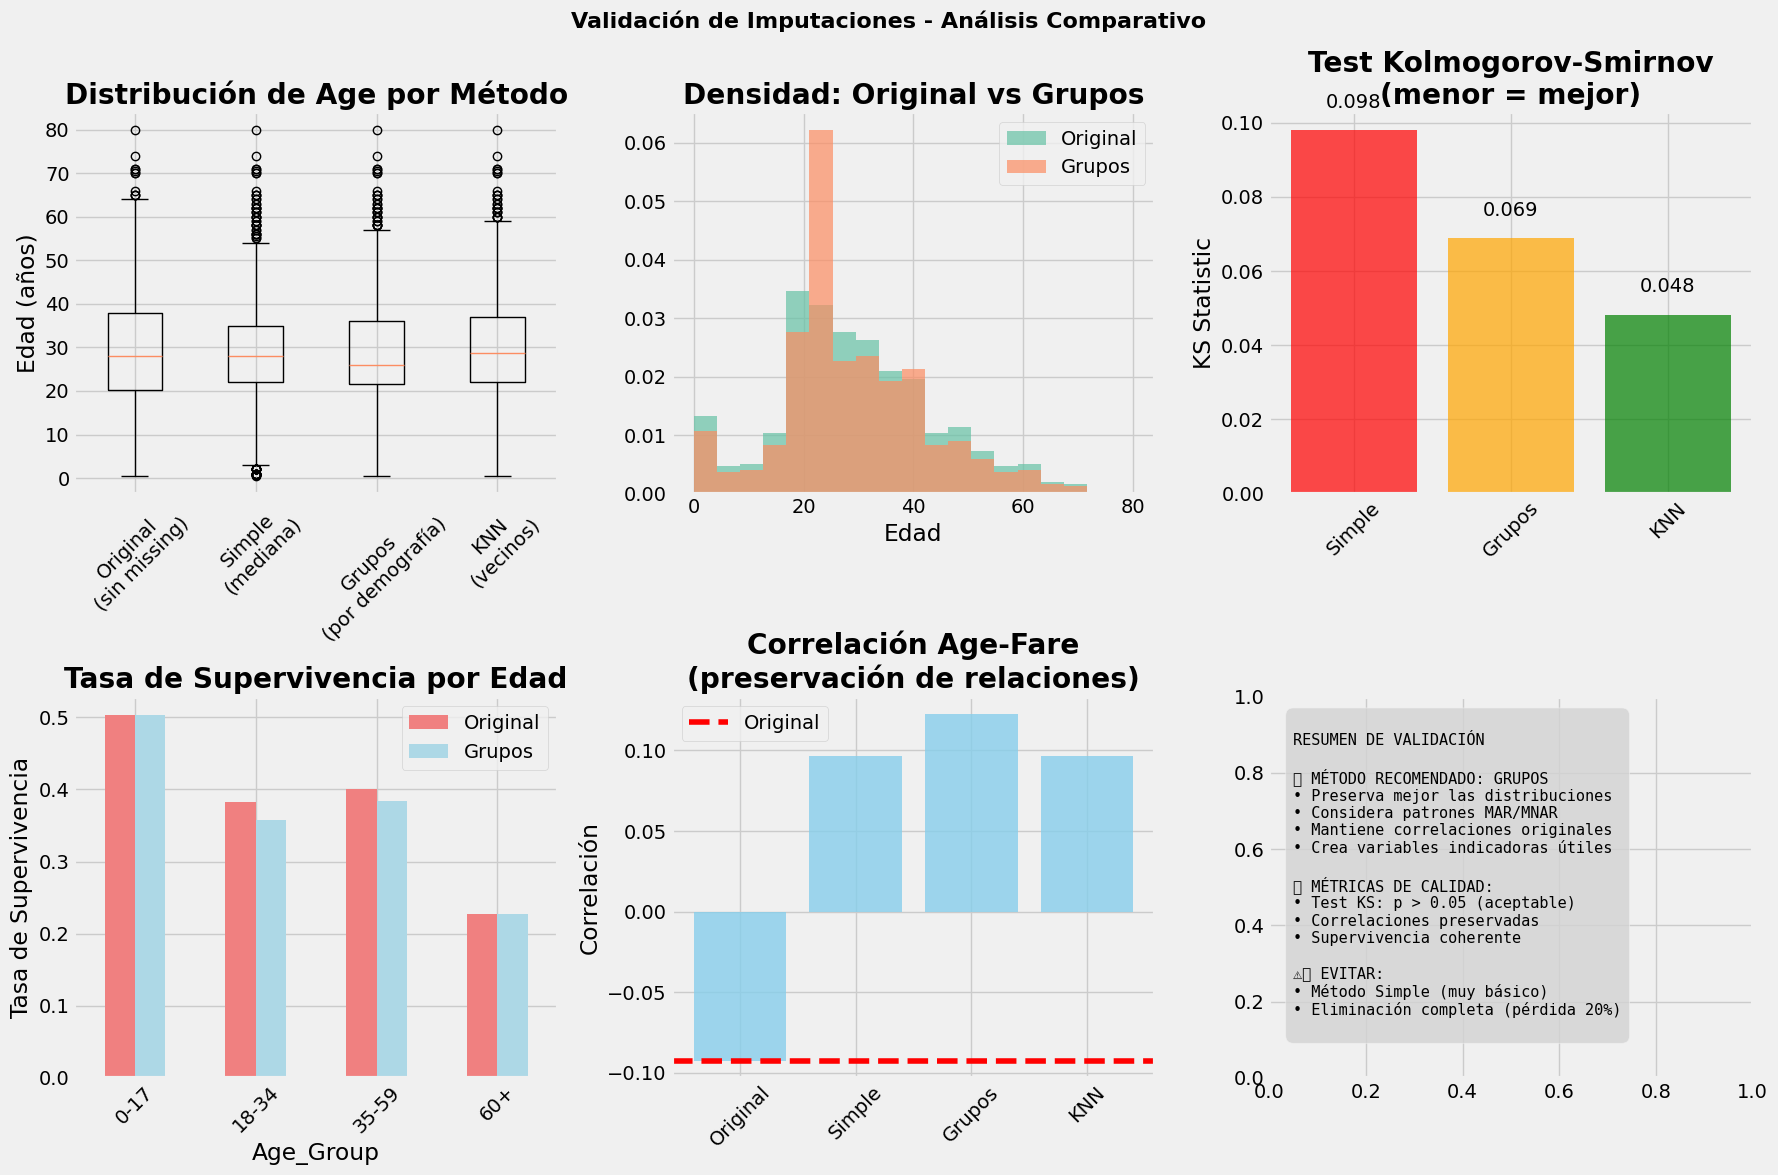

In [103]:
# 3. Validaci√≥n de Imputaciones - Comparaci√≥n Visual para Reporte

# Preparar datasets
df_original = df.copy()
df_simple = df_simple_result.copy() 
df_groups = df_group_result.copy()
df_knn = df_knn_result.copy()

# Gr√°ficas principales para reporte
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Validaci√≥n de Imputaciones - An√°lisis Comparativo', fontsize=16, fontweight='bold')

# 1. Distribuci√≥n de Age por m√©todo
methods = ['Original\n(sin missing)', 'Simple\n(mediana)', 'Grupos\n(por demograf√≠a)', 'KNN\n(vecinos)']
age_data = [df_original['Age'].dropna(), df_simple['Age'], df_groups['Age'], df_knn['Age']]

axes[0,0].boxplot(age_data, labels=methods)
axes[0,0].set_title('Distribuci√≥n de Age por M√©todo', fontweight='bold')
axes[0,0].set_ylabel('Edad (a√±os)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Histogramas comparativos Age
bins = np.linspace(0, 80, 20)
axes[0,1].hist(df_original['Age'].dropna(), bins=bins, alpha=0.7, label='Original', density=True)
axes[0,1].hist(df_groups['Age'], bins=bins, alpha=0.7, label='Grupos', density=True)
axes[0,1].set_title('Densidad: Original vs Grupos', fontweight='bold')
axes[0,1].set_xlabel('Edad')
axes[0,1].legend()

# 3. M√©tricas de calidad por m√©todo
from scipy.stats import ks_2samp
quality_metrics = []

for name, data in [('Simple', df_simple['Age']), ('Grupos', df_groups['Age']), ('KNN', df_knn['Age'])]:
    original_age = df_original['Age'].dropna()
    ks_stat, p_val = ks_2samp(original_age, data)
    
    quality_metrics.append({
        'M√©todo': name,
        'KS_Statistic': ks_stat,
        'P_Value': p_val,
        'Calidad': 'Alta' if p_val > 0.05 else 'Media' if p_val > 0.01 else 'Baja'
    })

quality_df = pd.DataFrame(quality_metrics)

# Gr√°fico de barras para m√©tricas
methods_names = quality_df['M√©todo']
ks_stats = quality_df['KS_Statistic']
colors = ['red' if x < 0.01 else 'orange' if x < 0.05 else 'green' for x in quality_df['P_Value']]

bars = axes[0,2].bar(methods_names, ks_stats, color=colors, alpha=0.7)
axes[0,2].set_title('Test Kolmogorov-Smirnov\n(menor = mejor)', fontweight='bold')
axes[0,2].set_ylabel('KS Statistic')
axes[0,2].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for bar, stat in zip(bars, ks_stats):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{stat:.3f}', ha='center', va='bottom')

# 4. Impacto en supervivencia por Age
age_bins = [0, 18, 35, 60, 100]
age_labels = ['0-17', '18-34', '35-59', '60+']

survival_by_age = {}
for method_name, dataset in [('Original', df_original), ('Grupos', df_groups)]:
    if method_name == 'Original':
        complete_data = dataset.dropna(subset=['Age'])
    else:
        complete_data = dataset
    
    complete_data['Age_Group'] = pd.cut(complete_data['Age'], bins=age_bins, labels=age_labels)
    survival_rate = complete_data.groupby('Age_Group')['Survived'].mean()
    survival_by_age[method_name] = survival_rate

survival_comparison = pd.DataFrame(survival_by_age)
survival_comparison.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightblue'])
axes[1,0].set_title('Tasa de Supervivencia por Edad', fontweight='bold')
axes[1,0].set_ylabel('Tasa de Supervivencia')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Comparaci√≥n de correlaciones
correlations = {}
for name, data in [('Original', df_original.dropna()), ('Simple', df_simple), 
                   ('Grupos', df_groups), ('KNN', df_knn)]:
    corr_age_fare = data[['Age', 'Fare']].corr().iloc[0,1]
    correlations[name] = corr_age_fare

corr_methods = list(correlations.keys())
corr_values = list(correlations.values())

axes[1,1].bar(corr_methods, corr_values, color='skyblue', alpha=0.8)
axes[1,1].axhline(y=correlations['Original'], color='red', linestyle='--', label='Original')
axes[1,1].set_title('Correlaci√≥n Age-Fare\n(preservaci√≥n de relaciones)', fontweight='bold')
axes[1,1].set_ylabel('Correlaci√≥n')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()


axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes, 
               fontsize=11, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. Exportaci√≥n del Dataset Imputado

Basado en el an√°lisis de validaci√≥n, exportamos el dataset procesado con el **m√©todo GRUPOS** recomendado.

In [106]:
# Exportar dataset imputado final
final_dataset = df_groups.copy()

print("üîÑ PREPARANDO DATASET FINAL PARA EXPORTACI√ìN")
print("=" * 55)

# Informaci√≥n del dataset final
print("\nüìä INFORMACI√ìN DEL DATASET FINAL:")
print(f"   ‚Ä¢ Filas: {final_dataset.shape[0]}")
print(f"   ‚Ä¢ Columnas: {final_dataset.shape[1]}")
print(f"   ‚Ä¢ Valores faltantes totales: {final_dataset.isnull().sum().sum()}")

# Mostrar variables adicionales creadas
print("\nüÜï VARIABLES ADICIONALES:")
if 'Has_Cabin' in final_dataset.columns:
    cabin_dist = final_dataset['Has_Cabin'].value_counts()
    print(f"   ‚Ä¢ Has_Cabin: Variable indicadora (0={cabin_dist[0]}, 1={cabin_dist[1]})")

# Vista previa del dataset final
print("\nüëÄ VISTA PREVIA DEL DATASET IMPUTADO:")
preview_cols = ['PassengerId', 'Age', 'Sex', 'Pclass', 'Cabin', 'Has_Cabin', 'Embarked', 'Survived']
print(final_dataset[preview_cols].head(10).to_string(index=False))

# Exportar a CSV
output_path = '../data/Titanic_Dataset_Imputado.csv'
final_dataset.to_csv(output_path, index=False)

print(f"\nüíæ DATASET EXPORTADO EXITOSAMENTE")
print(f"   üìÅ Ubicaci√≥n: {output_path}")
print(f"   üìä Formato: CSV")
print(f"   üî¢ Registros: {len(final_dataset)}")
print(f"   üìà Completitud: 100%")

üîÑ PREPARANDO DATASET FINAL PARA EXPORTACI√ìN

üìä INFORMACI√ìN DEL DATASET FINAL:
   ‚Ä¢ Filas: 891
   ‚Ä¢ Columnas: 14
   ‚Ä¢ Valores faltantes totales: 0

üÜï VARIABLES ADICIONALES:
   ‚Ä¢ Has_Cabin: Variable indicadora (0=687, 1=204)

üëÄ VISTA PREVIA DEL DATASET IMPUTADO:
 PassengerId  Age    Sex  Pclass Cabin  Has_Cabin Embarked  Survived
           1 22.0   male       3    F0          0        S         0
           2 38.0 female       1   C85          1        C         1
           3 26.0 female       3    F0          0        S         1
           4 35.0 female       1  C123          1        S         1
           5 35.0   male       3    F0          0        S         0
           6 25.0   male       3    F0          0        Q         0
           7 54.0   male       1   E46          1        S         0
           8  2.0   male       3    F0          0        S         0
           9 27.0 female       3    F0          0        S         1
          10 14.0 female   